In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
import textfeatures as tf
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import operator
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import roc_auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
data = pd.read_json("Video_Games_5.json",lines=True)

In [3]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [5]:
data.shape

(497577, 12)

In [33]:
print("Percentage of NaN value in our data, in each feature:")
((data.isna().sum()/data.shape[0])*100).round(3)

Percentage of NaN value in our data, in each feature:


overall            0.000
verified           0.000
reviewTime         0.000
reviewerID         0.000
asin               0.000
reviewerName       0.015
reviewText         0.032
summary            0.022
unixReviewTime     0.000
vote              78.336
style             41.871
image             99.270
dtype: float64

In [3]:
# We would not need "image" of the game or the console in our sentiment analysis
# We have above 99% of data missing in the field. Hence we would drop the data from our analysis
data.drop('image',inplace=True,axis = 1)
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN


In [40]:
# 'vote' field has around 78 % of missing data
# Lets analyze it more
data[data['vote'].notnull()].head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style
11,1,False,"05 15, 2012",A1LMJ9W8UX1H5B,0700026657,Rob NY,I've bought and played ALL of the ANNO games s...,SAY NO TO DRM!!,1337040000,28,NaN
12,5,True,"08 14, 2011",AN3YYDZAS3O1Y,0700099867,Bob,Loved playing Dirt 2 and I thought the graphic...,A step up from Dirt 2 and that is terrific!,1313280000,11,NaN
15,4,True,"06 14, 2011",A361M14PU2GUEG,0700099867,Angry Ryan,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,1308009600,2,NaN
16,5,False,"06 13, 2011",A2LQCBLLJVVR5T,0700099867,Timmiley,This is a must have for any gamer. Codemasters...,BEST GRAPHICS OF ANY GAME SO FAR !!!!,1307923200,14,NaN
19,4,False,"12 26, 2012",A2GPRA9HHLOC4B,0700026398,Wicasawakan,I will open with the Pros:\nReplayability - It...,Great game with design flaws,1356480000,12,NaN


In [4]:
# for Sentiment analysis we will not need vote feature as it has more than 78% of the data missing
data.drop('vote',inplace=True,axis = 1)
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN


In [5]:
print("Percentage of NaN value in our data, now:")
((data.isna().sum()/data.shape[0])*100).round(3)

Percentage of NaN value in our data, now:


overall            0.000
verified           0.000
reviewTime         0.000
reviewerID         0.000
asin               0.000
reviewerName       0.015
reviewText         0.032
summary            0.022
unixReviewTime     0.000
style             41.871
dtype: float64

In [6]:
# Lets analyze 'style' feeature
data[data['style'].notnull()].head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style
46,4,True,"02 23, 2017",AQQQ3IA92VBGR,0804161380,Steven Rea,The metal bookmark has a couple of weird flaws...,Nice set,1487808000,{'Format:': ' Hardcover'}
47,5,True,"01 23, 2017",A1DWHVHU20K6RH,0804161380,D Comrey,Awesome,Five Stars,1485129600,{'Format:': ' Hardcover'}
48,5,True,"08 27, 2016",A2RPG0G1UGUFKL,0804161380,Amazon Customer,Glad I got this for my collection,Five Stars,1472256000,{'Format:': ' Hardcover'}
49,5,True,"04 18, 2016",A1U08MKZHEMMRC,0804161380,Wadev3,Very nicely put together. Crisp and clean and...,Five Stars,1460937600,{'Format:': ' Hardcover'}
50,5,True,"03 29, 2016",A2CJJSZGRCTBQ0,0804161380,Alejandro Garcia,The box it's in perfect condition and the book...,The box it's in perfect condition and the book...,1459209600,{'Format:': ' Hardcover'}


In [5]:
# 'style' contains format, edition and platform details of the game.
# Since there is over 40 % of the data missing we will not be able to
# fill the missing pieces with reasonable data
# Hence dropping the feature
data.drop('style',inplace=True,axis = 1)
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


In [6]:
# Since we already have the Unix timestamp we will not be needing the other time format
data.drop('reviewTime',inplace=True,axis = 1)
data.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,True,A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


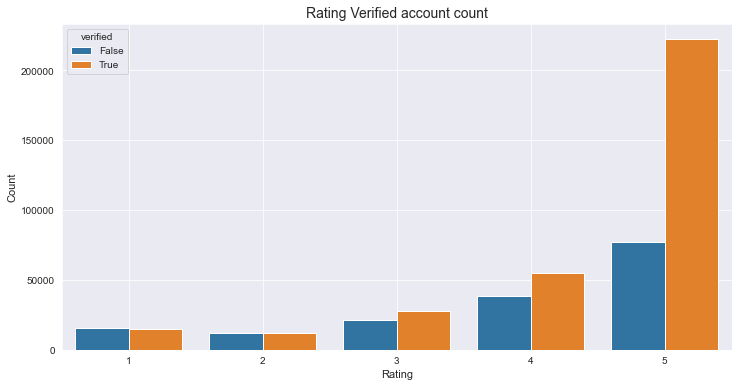

In [28]:
# Let us analyze the 'verified' feature
# We could see that the Verified accounts have voted much more than the non-verified
sns.set_style('dark')
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data = data,x = 'overall',hue='verified',ax=ax)
plt.title("Rating Verified account count", size = 14)
plt.xlabel("Rating", size=11)
plt.ylabel("Count", size=11)
plt.grid()
plt.show()

In [7]:
#Sentiment of the review will not be determined by the unique numbers'asin', 'reviewerID' and 'reviewerName'
# Here we are not building a recommendation system, we are building a sentiment analysis model
# Hence we can drop all the user - item features
data.drop(['asin','reviewerID','reviewerName'],inplace=True,axis = 1)
data.head()

,overall,verified,reviewText,summary,unixReviewTime
0,5,True,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,ok game.,Three Stars,1424649600
3,2,True,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"great game, I love it and have played it since...",love this game,1419465600


In [34]:
print("Percentage of NaN value in our data, now:")
((data.isna().sum()/data.shape[0])*100).round(3)

Percentage of NaN value in our data, now:


overall           0.000
verified          0.000
reviewText        0.032
summary           0.022
unixReviewTime    0.000
dtype: float64

In [8]:
# Lets Drop all the nan values here
data.dropna(inplace=True)
((data.isna().sum()/data.shape[0])*100).round(3)

overall           0.0
verified          0.0
reviewText        0.0
summary           0.0
unixReviewTime    0.0
dtype: float64

# EDA

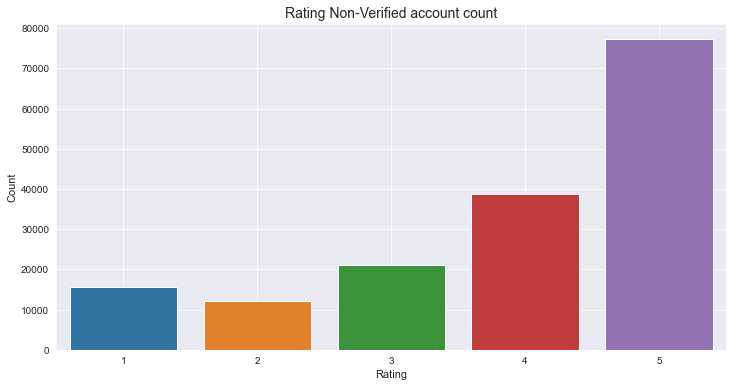

In [41]:
sns.set_style('dark')
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data = data[data.verified==False],x = 'overall',ax=ax)
plt.title("Rating Non-Verified account count", size = 14)
plt.xlabel("Rating", size=11)
plt.ylabel("Count", size=11)
plt.grid()
plt.show()

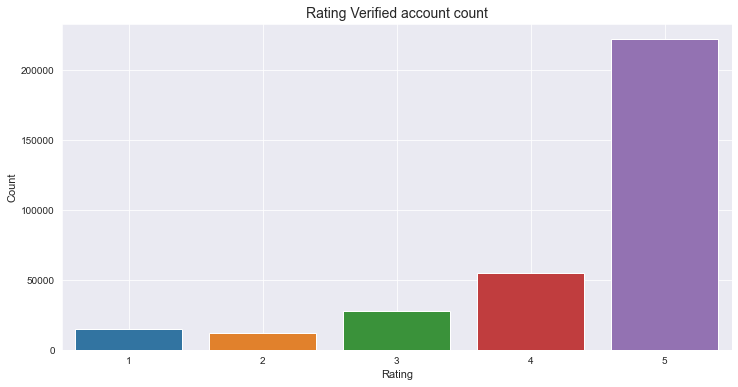

In [42]:
sns.set_style('dark')
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data = data[data.verified==True],x = 'overall',ax=ax)
plt.title("Rating Verified account count", size = 14)
plt.xlabel("Rating", size=11)
plt.ylabel("Count", size=11)
plt.grid()
plt.show()

In [44]:
# Most of the games have been reviewed to be very good
(data['overall'].value_counts()/data.shape[0])*100

5    60.231523
4    18.828270
3     9.880639
1     6.207723
2     4.851845
Name: overall, dtype: float64

In [9]:
# In our analysis, we would not be dealing with all these class lables
# We would need to determine if a review is correctly positive or is a review negative
# From here we can assume that any review which is below 3 is a negative review and above 3 is positive
# We are dropping the '3' rating from our dataset and chaing our lables to a binary one
data['review'] = 0
mask1 = (data.overall==3)
mask2 = (data.overall>3)
data.loc[mask1,'review'] = data.loc[mask1,'review'].replace(to_replace=0,value=3)
data.loc[mask2,'review'] = data.loc[mask2,'review'].replace(to_replace=0,value=1)
data = data[data.overall!=3]
data.head()

,overall,verified,reviewText,summary,unixReviewTime,review
0,5,True,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,1
1,4,False,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,1
3,2,True,"found the game a bit too complicated, not what...",Two Stars,1424390400,0
4,5,True,"great game, I love it and have played it since...",love this game,1419465600,1
5,4,True,i liked a lot some time that i haven't play a ...,Anno 2070,1415836800,1


In [54]:
data.shape

(448178, 6)

In [10]:
# Now we can drop our 'overall' feature
data.drop('overall',axis = 1,inplace=True)
data.head()

,verified,reviewText,summary,unixReviewTime,review
0,True,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,1
1,False,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,1
3,True,"found the game a bit too complicated, not what...",Two Stars,1424390400,0
4,True,"great game, I love it and have played it since...",love this game,1419465600,1
5,True,i liked a lot some time that i haven't play a ...,Anno 2070,1415836800,1


In [11]:
# We would not need time as well in our sentiment detection.
data.drop('unixReviewTime',axis = 1,inplace=True)
data.head()

,verified,reviewText,summary,review
0,True,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1
1,False,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1
3,True,"found the game a bit too complicated, not what...",Two Stars,0
4,True,"great game, I love it and have played it since...",love this game,1
5,True,i liked a lot some time that i haven't play a ...,Anno 2070,1


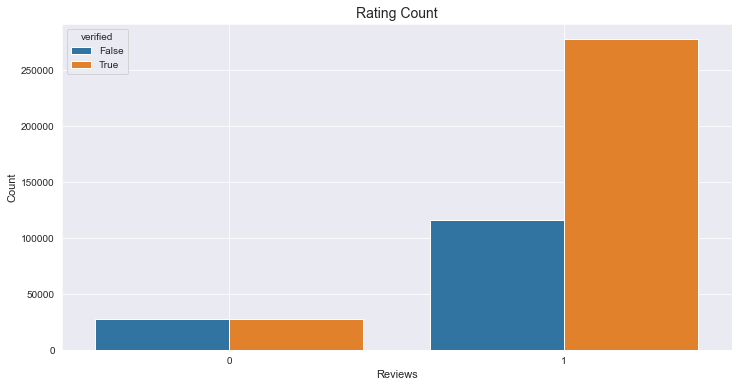

In [23]:
sns.set_style('dark')
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data = data,x = 'review',hue='verified',ax=ax)
plt.title("Rating Count", size = 14)
plt.xlabel("Reviews", size=11)
plt.ylabel("Count", size=11)
plt.grid()
plt.show()

In [21]:
# This data is highly imbalance, hence we might need to use sampling. 
# We would use sampling if needed
(data['review'].value_counts()/data.shape[0])*100

1    87.727867
0    12.272133
Name: review, dtype: float64

In [31]:
# Lets see some of the Negative reviews
list(data[data.review==0]['summary'])[:10]

['Two Stars',
 'Avoid This Game - Filled with Bugs',
 'SAY NO TO DRM!!',
 'Requires steam',
 'Skip!',
 'Requires constant online access. This is only the loader.',
 'It might have been a good game, but I never found out because the ...',
 'Wrong key',
 "Couldn't get this one to work",
 'The first one was much better.']

In [32]:
list(data[data.review==0]['reviewText'])[:10]

['found the game a bit too complicated, not what I expected after having played 1602, 1503, and 1701',
 "I'm an avid gamer, but Anno 2070 is an INSULT to gaming.  It is so buggy and half-finished that the first campaign doesn't even work properly and the DRM is INCREDIBLY frustrating to deal with.\n\nOnce you manage to work your way past the massive amounts of bugs and get through the DRM, HOURS later you finally figure out that the game has no real tutorial, so you stuck just clicking around randomly.\n\nSad, sad, sad, example of a game that could have been great but FTW.",
 "I've bought and played ALL of the ANNO games since 1602, and spent more hours than I can even count building massive empires with extremely complex trade routes. I was thrilled to see another installment released, but I absolutely will NOT pay for something that limits my hardware changes and installs.\n\nWake up UBI, look at all of your other software title reviews, both here on Amazon and on gaming sites. Peopl

In [12]:
# It could be observed that most the sentiment could be determined by just looking at the 'summary'
# Hence we would weight the 'summary' more than the others
# Lets create a new feature with  repeating the summary 3 times\
data.reset_index(drop=True)
data['space'] = " "
data['summary_weighted'] = data['summary'] + data['space']+data['summary'] + data['space']+data['summary'] + data['space']
data.head()

,verified,reviewText,summary,review,space,summary_weighted
0,True,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1,,but when you do it's great. but when you do it...
1,False,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1,,"But in spite of that it was fun, I liked it Bu..."
3,True,"found the game a bit too complicated, not what...",Two Stars,0,,Two Stars Two Stars Two Stars
4,True,"great game, I love it and have played it since...",love this game,1,,love this game love this game love this game
5,True,i liked a lot some time that i haven't play a ...,Anno 2070,1,,Anno 2070 Anno 2070 Anno 2070


In [84]:
# Lets see if there is any duplicate data
print(f'There are {(data[data.duplicated()].shape[0]/data.shape[0])*100} % of duplicate data')

There are 18.307235071779516 % of duplicate data


In [13]:
# Lets drop the duplicate data and proceed with our work
data = data[~data.duplicated()]
data.shape

(366129, 6)

In [14]:
data.drop('summary',axis = 1,inplace=True)
data.reset_index(inplace=True)
data.head()

,index,verified,reviewText,review,space,summary_weighted
0,0,True,"This game is a bit hard to get the hang of, bu...",1,,but when you do it's great. but when you do it...
1,1,False,I played it a while but it was alright. The st...,1,,"But in spite of that it was fun, I liked it Bu..."
2,3,True,"found the game a bit too complicated, not what...",0,,Two Stars Two Stars Two Stars
3,4,True,"great game, I love it and have played it since...",1,,love this game love this game love this game
4,5,True,i liked a lot some time that i haven't play a ...,1,,Anno 2070 Anno 2070 Anno 2070


In [15]:
data.drop(['space','index'],axis = 1,inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,verified,reviewText,review,summary_weighted
0,True,"This game is a bit hard to get the hang of, bu...",1,but when you do it's great. but when you do it...
1,False,I played it a while but it was alright. The st...,1,"But in spite of that it was fun, I liked it Bu..."
2,True,"found the game a bit too complicated, not what...",0,Two Stars Two Stars Two Stars
3,True,"great game, I love it and have played it since...",1,love this game love this game love this game
4,True,i liked a lot some time that i haven't play a ...,1,Anno 2070 Anno 2070 Anno 2070


# Data Cleaning

In [16]:
data.isna().sum()

verified            0
reviewText          0
review              0
summary_weighted    0
dtype: int64

"textfeatures" library calculates basic features in our data.
The column name is self explanatory in this case. 

In [43]:
# Adding some basic features
new_feat = pd.DataFrame()
new_feat['reviewText'] = data['reviewText'].astype(str)
new_feat['summary_weighted'] = data['summary_weighted'].astype(str)
tf.word_count(new_feat,"reviewText","word_cnt_rev")
tf.word_count(new_feat,"summary_weighted","word_cnt_sum")
tf.char_count(new_feat,"reviewText","char_len_rev")
tf.char_count(new_feat,"summary_weighted","char_len_sum")
tf.avg_word_length(new_feat,"reviewText","avg_wrd_length_rev")
tf.avg_word_length(new_feat,"summary_weighted","avg_wrd_length_sum")
tf.stopwords_count(new_feat,"reviewText","stopwords_cnt_rev")
tf.stopwords_count(new_feat,"summary_weighted","stopwords_cnt_sum")
tf.links_count(new_feat,"reviewText","links_count_rev")
tf.links_count(new_feat,"summary_weighted","links_count_sum")
tf.numerics_count(new_feat,"reviewText","num_len_rev")
tf.numerics_count(new_feat,"summary_weighted","num_len_sum")
new_feat.head()

,reviewText,summary_weighted,word_cnt_rev,word_cnt_sum,char_len_rev,char_len_sum,avg_wrd_length_rev,avg_wrd_length_sum,stopwords_cnt_rev,stopwords_cnt_sum,links_count_rev,links_count_sum,num_len_rev,num_len_sum
0,"This game is a bit hard to get the hang of, bu...",but when you do it's great. but when you do it...,17,19,71,84,3.235294,3.666667,9,15,0,0,0,0
1,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it Bu...",66,34,297,132,3.515152,3.000000,31,18,0,0,1,0
2,"found the game a bit too complicated, not what...",Two Stars Two Stars Two Stars,18,7,98,30,4.500000,4.000000,8,0,0,0,1,0
3,"great game, I love it and have played it since...",love this game love this game love this game,12,10,58,45,3.916667,4.000000,5,3,0,0,0,0
4,i liked a lot some time that i haven't play a ...,Anno 2070 Anno 2070 Anno 2070,21,7,105,30,4.047619,4.000000,9,0,0,0,0,3


In [17]:
# Deconstructing to get a more readable text
a = []
b = []
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
for i in tqdm(data['summary_weighted']):
    a.append(decontracted(i))
for i in tqdm(data['reviewText']):
    b.append(decontracted(i))
data['summary_weighted'] = pd.DataFrame(a,columns=["summary_weighted"]).values
data['reviewText'] = pd.DataFrame(b,columns=["reviewText"]).values
# Checking one of the phrsaes
data['reviewText'].values[154]

100%|███████████████████████████████████████████████████████████████████████| 366129/366129 [00:12<00:00, 30441.13it/s]


'My son sayes he is still learning how to customize the levels and is having some trouble changing ships. He liked 2006 better as it is easier to use. Will get in there and read the book..'

In [18]:
data.isna().sum()

verified            0
reviewText          0
review              0
summary_weighted    0
dtype: int64

In [19]:
# Cleaning data of links, alphanumeric words, and other non essential elements
# We are not removing any stop words from here.
# We would use the stop word removal at later part of our analysis
def clean_text(data):    
    pro_sum = []
    for sentance in tqdm(data.values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stops)
        pro_sum.append(sentance.strip())
    return pro_sum
pro_sum = clean_text(data['summary_weighted'])
data['summary_weighted'] = pd.DataFrame(pro_sum,columns=["summary_weighted"]).values
pro_sum = clean_text(data['reviewText'])
data['reviewText'] = pd.DataFrame(pro_sum,columns=["reviewText"]).values
data.head()

100%|████████████████████████████████████████████████████████████████████████| 366129/366129 [05:31<00:00, 1102.80it/s]


,verified,reviewText,review,summary_weighted
0,True,This game is a bit hard to get the hang of but...,1,but when you do it is great but when you do it...
1,False,I played it a while but it was alright The ste...,1,But in spite of that it was fun I liked it But...
2,True,found the game a bit too complicated not what ...,0,Two Stars Two Stars Two Stars
3,True,great game I love it and have played it since ...,1,love this game love this game love this game
4,True,i liked a lot some time that i have not play a...,1,Anno Anno Anno


In [24]:
data['reviewText'].values[154]

'My son sayes he is still learning how to customize the levels and is having some trouble changing ships He liked better as it is easier to use Will get in there and read the book'

In [32]:
# https://gist.github.com/mkulakowski2
# Checking how many negative words and positive words are present in our text
def pos_neg(paragraph):
    def readwords(filename):
        f = open(filename)
        words = [ line.rstrip() for line in f.readlines()]
        return words

    positive = readwords('positive.txt')
    negative = readwords('negative.txt')
    count = Counter(paragraph.split())

    pos = 0
    neg = 0
    for key, val in count.items():
        key = key.rstrip('.,?!\n')
        if key in positive:
            pos += val
        if key in negative:
            neg += val
    return pos,neg

In [33]:
summ_pos = []
sum_neg = []
rev_pos = []
rev_neg = []
for i in tqdm(data['reviewText']):
    p,n = pos_neg(i)
    rev_pos.append(p)
    rev_neg.append(n)
for i in tqdm(data['summary_weighted']):
    p,n = pos_neg(i)
    summ_pos.append(p)
    sum_neg.append(n)

100%|█████████████████████████████████████████████████████████████████████████| 366129/366129 [23:29<00:00, 259.80it/s]


In [41]:
data['review_positive'] = rev_pos
data['review_negetive'] = rev_neg
data['summary_positive'] = summ_pos
data['summary_negative'] = summ_pos
data.head()

,verified,reviewText,review,summary_weighted,review_positive,review_negetive,summary_positive,summary_negative
0,True,This game is a bit hard to get the hang of but...,1,but when you do it is great but when you do it...,1,2,3,1
1,False,I played it a while but it was alright The ste...,1,But in spite of that it was fun I liked it But...,3,3,6,3
2,True,found the game a bit too complicated not what ...,0,Two Stars Two Stars Two Stars,0,1,0,0
3,True,great game I love it and have played it since ...,1,love this game love this game love this game,2,0,3,2
4,True,i liked a lot some time that i have not play a...,1,Anno Anno Anno,2,1,0,2


In [3]:
# We can calculate the positive-negative ratio
# and also negative-positive ratio
data['review_negative_positive_ratio'] = data['review_negetive']/data['review_positive']
data['review_positive_negative_ratio'] = data['review_positive']/data['review_negetive']
data['summary_positive_negative_ratio'] = data['summary_positive']/data['summary_negative']
data['summary_negative_positive_ratio'] = data['summary_negative']/data['summary_positive']
data.head()

,verified,reviewText,review,summary_weighted,review_positive,review_negetive,summary_positive,summary_negative,review_negative_positive_ratio,review_positive_negative_ratio,summary_positive_negative_ratio,summary_negative_positive_ratio
0,True,This game is a bit hard to get the hang of but...,1,but when you do it is great but when you do it...,1,2,3,1,2.0,0.5,3.0,0.333333
1,False,I played it a while but it was alright The ste...,1,But in spite of that it was fun I liked it But...,3,3,6,3,1.0,1.0,2.0,0.500000
2,True,found the game a bit too complicated not what ...,0,Two Stars Two Stars Two Stars,0,1,0,0,inf,0.0,NaN,NaN
3,True,great game I love it and have played it since ...,1,love this game love this game love this game,2,0,3,2,0.0,inf,1.5,0.666667
4,True,i liked a lot some time that i have not play a...,1,Anno Anno Anno,2,1,0,2,0.5,2.0,0.0,inf


In [46]:
data.isna().sum()

verified                               0
reviewText                             0
review                                 0
summary_weighted                       0
review_positive                        0
review_negetive                        0
summary_positive                       0
summary_negative                       0
review_negative_positive_ratio     17040
review_positive_negative_ratio     17040
summary_positive_negative_ratio    19890
summary_negative_positive_ratio    19890
dtype: int64

In [4]:
# Lets replace all the NaN and inf with zero
# The NaN's are caused due to zeros present at many fields
data.fillna(value=0,inplace=True)
data.replace([np.inf, -np.inf], 0,inplace=True)

In [50]:
data.head()

,verified,reviewText,review,summary_weighted,review_positive,review_negetive,summary_positive,summary_negative,review_negative_positive_ratio,review_positive_negative_ratio,summary_positive_negative_ratio,summary_negative_positive_ratio
0,True,This game is a bit hard to get the hang of but...,1,but when you do it is great but when you do it...,1,2,3,1,2.0,0.5,3.0,0.333333
1,False,I played it a while but it was alright The ste...,1,But in spite of that it was fun I liked it But...,3,3,6,3,1.0,1.0,2.0,0.500000
2,True,found the game a bit too complicated not what ...,0,Two Stars Two Stars Two Stars,0,1,0,0,0.0,0.0,0.0,0.000000
3,True,great game I love it and have played it since ...,1,love this game love this game love this game,2,0,3,2,0.0,0.0,1.5,0.666667
4,True,i liked a lot some time that i have not play a...,1,Anno Anno Anno,2,1,0,2,0.5,2.0,0.0,0.000000


In [20]:
# Lets get rid of all the stop words
# Cleaning data of links, alphanumeric words, and other non essential elements
stops = {"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"}

def clean_text(data):    
    pro_sum = []
    for sentance in tqdm(data.values):
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stops)
        pro_sum.append(sentance.strip())
    return pro_sum
pro_sum = clean_text(data['reviewText'])
data['reviewText'] = pd.DataFrame(pro_sum,columns=["reviewText"]).values
pro_sum = clean_text(data['summary_weighted'])
data['summary_weighted'] = pd.DataFrame(pro_sum,columns=["summary_weighted"]).values
#data.head()

100%|███████████████████████████████████████████████████████████████████████| 366129/366129 [00:03<00:00, 97870.03it/s]


In [53]:
data.isna().sum()

verified                           0
reviewText                         0
review                             0
summary_weighted                   0
review_positive                    0
review_negetive                    0
summary_positive                   0
summary_negative                   0
review_negative_positive_ratio     0
review_positive_negative_ratio     0
summary_positive_negative_ratio    0
summary_negative_positive_ratio    0
dtype: int64

In [58]:
# Lets check out the positivity and negativity of the review and summary
# Positivity = no of positive words/no of words in the string
# Negativity = no of negative words/no of words on the string
# Also let's find out the number of words in review and summary
data['summary_count'] = data['summary_weighted'].str.split().str.len()
data['review_count'] = data['reviewText'].str.split().str.len()
data['summ_pos'] = data['summary_positive']/data['summary_count']
data['summ_neg'] = data['summary_negative']/data['summary_count']
data['rev_pos'] = data['review_positive']/data['review_count']
data['rev_neg'] = data['review_negetive']/data['review_count']
data.head()

,verified,reviewText,review,summary_weighted,review_positive,review_negetive,summary_positive,summary_negative,review_negative_positive_ratio,review_positive_negative_ratio,summary_positive_negative_ratio,summary_negative_positive_ratio,summary_count,review_count,summ_pos,summ_neg,rev_pos,rev_neg
0,True,game bit hard hang great,1,great great great,1,2,3,1,2.0,0.5,3.0,0.333333,3,5,1.0,0.333333,0.200000,0.400000
1,False,played alright steam bit trouble game steam ha...,1,spite fun spite fun spite fun,3,3,6,3,1.0,1.0,2.0,0.500000,6,18,1.0,0.500000,0.166667,0.166667
2,True,game bit complicated expected played,0,stars stars stars,0,1,0,0,0.0,0.0,0.0,0.000000,3,5,0.0,0.000000,0.000000,0.200000
3,True,great game love played arrived,1,love game love game love game,2,0,3,2,0.0,0.0,1.5,0.666667,6,5,0.5,0.333333,0.400000,0.000000
4,True,lot time play wonderfull game simply funny gam...,1,anno anno anno,2,1,0,2,0.5,2.0,0.0,0.000000,3,11,0.0,0.666667,0.181818,0.090909


In [59]:
data.isna().sum()

verified                              0
reviewText                            0
review                                0
summary_weighted                      0
review_positive                       0
review_negetive                       0
summary_positive                      0
summary_negative                      0
review_negative_positive_ratio        0
review_positive_negative_ratio        0
summary_positive_negative_ratio       0
summary_negative_positive_ratio       0
summary_count                         0
review_count                          0
summ_pos                           5679
summ_neg                            828
rev_pos                             935
rev_neg                            1665
dtype: int64

In [60]:
# Lets replace all the NaN and inf with zero
# The NaN's are caused due to zeros present at many fields
data.fillna(value=0,inplace=True)
data.replace([np.inf, -np.inf,np.nan], 0,inplace=True)
data.isna().sum()

verified                           0
reviewText                         0
review                             0
summary_weighted                   0
review_positive                    0
review_negetive                    0
summary_positive                   0
summary_negative                   0
review_negative_positive_ratio     0
review_positive_negative_ratio     0
summary_positive_negative_ratio    0
summary_negative_positive_ratio    0
summary_count                      0
review_count                       0
summ_pos                           0
summ_neg                           0
rev_pos                            0
rev_neg                            0
dtype: int64

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
review,366129.0,0.861287,0.345648,0.0,1.000000,1.000000,1.000000,1.000000
review_positive,366129.0,7.889820,12.002586,0.0,2.000000,4.000000,9.000000,357.000000
review_negetive,366129.0,3.430272,7.215696,0.0,0.000000,1.000000,4.000000,227.000000
summary_positive,366129.0,2.317929,2.435438,0.0,0.000000,3.000000,3.000000,36.000000
summary_negative,366129.0,7.889820,12.002586,0.0,2.000000,4.000000,9.000000,357.000000
review_negative_positive_ratio,366129.0,0.361183,0.581929,0.0,0.000000,0.181818,0.500000,19.000000
review_positive_negative_ratio,366129.0,1.670963,2.474278,0.0,0.000000,1.000000,2.444444,51.000000
summary_positive_negative_ratio,366129.0,0.630278,0.998584,0.0,0.000000,0.187500,0.900000,15.000000
summary_negative_positive_ratio,366129.0,1.424202,2.987832,0.0,0.000000,0.333333,1.666667,119.000000
summary_count,366129.0,7.159559,4.790826,0.0,3.000000,6.000000,9.000000,51.000000


In [22]:
data.isna().sum()

verified            0
reviewText          0
review              0
summary_weighted    0
dtype: int64

## Combining features

In [48]:
new_feat.head()

,reviewText,summary_weighted,word_cnt,char_len,avg_wrd_length,stopwords_cnt,links_count,num_len
0,"This game is a bit hard to get the hang of, bu...",but when you do it's great. but when you do it...,19,84,3.666667,15,0,0
1,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it Bu...",34,132,3.000000,18,0,0
2,"found the game a bit too complicated, not what...",Two Stars Two Stars Two Stars,7,30,4.000000,0,0,0
3,"great game, I love it and have played it since...",love this game love this game love this game,10,45,4.000000,3,0,0
4,i liked a lot some time that i haven't play a ...,Anno 2070 Anno 2070 Anno 2070,7,30,4.000000,0,0,3


In [24]:
#df[['reviewText', 'review', 'summary_weighted']] = data1[['reviewText', 'review', 'summary_weighted']]
data[['review_positive', 'review_negetive', 'summary_positive',
       'summary_negative', 'review_negative_positive_ratio',
       'review_positive_negative_ratio', 'summary_positive_negative_ratio',
       'summary_negative_positive_ratio', 'summary_count', 'review_count',
       'summ_pos', 'summ_neg', 'rev_pos', 'rev_neg', 'word_cnt_rev',
       'word_cnt_sum', 'char_len_rev', 'char_len_sum', 'avg_wrd_length_rev',
       'avg_wrd_length_sum', 'stopwords_cnt_rev', 'stopwords_cnt_sum',
       'links_count_rev', 'links_count_sum', 'num_len_rev', 'num_len_sum']] = new_feat[['review_positive', 'review_negetive', 'summary_positive',
       'summary_negative', 'review_negative_positive_ratio',
       'review_positive_negative_ratio', 'summary_positive_negative_ratio',
       'summary_negative_positive_ratio', 'summary_count', 'review_count',
       'summ_pos', 'summ_neg', 'rev_pos', 'rev_neg', 'word_cnt_rev',
       'word_cnt_sum', 'char_len_rev', 'char_len_sum', 'avg_wrd_length_rev',
       'avg_wrd_length_sum', 'stopwords_cnt_rev', 'stopwords_cnt_sum',
       'links_count_rev', 'links_count_sum', 'num_len_rev', 'num_len_sum']]
data.isna().sum()

verified                           0
reviewText                         0
review                             0
summary_weighted                   0
review_positive                    0
review_negetive                    0
summary_positive                   0
summary_negative                   0
review_negative_positive_ratio     0
review_positive_negative_ratio     0
summary_positive_negative_ratio    0
summary_negative_positive_ratio    0
summary_count                      0
review_count                       0
summ_pos                           0
summ_neg                           0
rev_pos                            0
rev_neg                            0
word_cnt_rev                       0
word_cnt_sum                       0
char_len_rev                       0
char_len_sum                       0
avg_wrd_length_rev                 0
avg_wrd_length_sum                 0
stopwords_cnt_rev                  0
stopwords_cnt_sum                  0
links_count_rev                    0
l

In [26]:
data.columns

Index(['verified', 'reviewText', 'review', 'summary_weighted',
       'review_positive', 'review_negetive', 'summary_positive',
       'summary_negative', 'review_negative_positive_ratio',
       'review_positive_negative_ratio', 'summary_positive_negative_ratio',
       'summary_negative_positive_ratio', 'summary_count', 'review_count',
       'summ_pos', 'summ_neg', 'rev_pos', 'rev_neg', 'word_cnt_rev',
       'word_cnt_sum', 'char_len_rev', 'char_len_sum', 'avg_wrd_length_rev',
       'avg_wrd_length_sum', 'stopwords_cnt_rev', 'stopwords_cnt_sum',
       'links_count_rev', 'links_count_sum', 'num_len_rev', 'num_len_sum'],
      dtype='object')

In [28]:
data.head()

,verified,reviewText,review,summary_weighted,review_positive,review_negetive,summary_positive,summary_negative,review_negative_positive_ratio,review_positive_negative_ratio,...,char_len_rev,char_len_sum,avg_wrd_length_rev,avg_wrd_length_sum,stopwords_cnt_rev,stopwords_cnt_sum,links_count_rev,links_count_sum,num_len_rev,num_len_sum
0,True,game bit hard hang great,1,great great great,1,2,3,1,2.0,0.5,...,71,84,3.235294,3.666667,9,15,0,0,0,0
1,False,played alright steam bit trouble game steam ha...,1,spite fun spite fun spite fun,3,3,6,3,1.0,1.0,...,297,132,3.515152,3.000000,31,18,0,0,1,0
2,True,game bit complicated expected played,0,stars stars stars,0,1,0,0,0.0,0.0,...,98,30,4.500000,4.000000,8,0,0,0,1,0
3,True,great game love played arrived,1,love game love game love game,2,0,3,2,0.0,0.0,...,58,45,3.916667,4.000000,5,3,0,0,0,0
4,True,lot time play wonderfull game simply funny gam...,1,anno anno anno,2,1,0,2,0.5,2.0,...,105,30,4.047619,4.000000,9,0,0,0,0,3


## Text to Number

In [2]:
y = pd.read_pickle("y_all.pkl")
data=pd.read_pickle('data.pkl')

In [3]:
# Lets perform Stemming
def stemming_word(data,splitting = True,type_of = "snow"):
    if type_of.lower() == "snow":
        stemmer = SnowballStemmer('english')
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        print("End of Word Stemming\n")
        return a
    if type_of.lower() == "porter":
        stemmer = PorterStemmer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        print("End of Word Stemming\n")
        return a
    if type_of.lower()=="lemm":
        lem = WordNetLemmatizer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [lem.lemmatize(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [lem.lemmatize(y) for y in k])
            a = a.str.join("")
        print("End of Word Stemming\n")
        return a
    else:
        print("Plese Select the mentioned Options for 'type_of' field:\n")
        print("1>'Snow': SnowballStemmer\n2>'Porter':PorterStemmer\n3>'Lemm':WordNetLemmatizer")
        print("End of Word Stemming\n")

In [4]:
# Let us check the correlation among the features
def create_conrr(mat):
    sns.set_style("dark")
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(mat.corr().round(3), annot=True,cmap="YlGnBu")
    plt.grid()
    plt.title("Feature Correlation", size = 20)
    plt.show()

In [5]:
# We would try and visualize with TSNE
# Check with method is seperating our data best
# Then use that in our final model
def text_to_numbers(data,model='BOW',gram=1,feat_names=False):
    if model.lower()=='bow':
        vectorizer = CountVectorizer(ngram_range=(1, gram))
        x = vectorizer.fit_transform(data)
        if feat_names==True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            print("End of Word String to Vector\n")
            return word_freq            
        else:
            print("End of Word String to Vector\n")
            return x
    if model.lower()=='tfidf':
        vectorizer = TfidfVectorizer()
        x = vectorizer.fit_transform(data)
        if feat_names== True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            print("End of Word String to Vector\n")
            return word_freq
        else:
            print("End of Word String to Vector\n")
            return x
    else:
        print("Please enter: \n'model':\n 'BOW': Bag of Words\n 'TFIDF':TF-IDF\n'gram' for N_Gram: mention a nunber(Between 1-4) if 'BOW'is closen\n")
        print("If you want the feature names, please make 'feat_names' as true\nThis would only return the geature names")
        print("End of Word String to Vector\n")

In [6]:
# WordCloud
def word_cloud(data,model = "BOW",gram=1,n_words=100,title="Email"):
    word_freq = text_to_numbers(data,model,gram,feat_names=True)
    features_freq = dict(sorted(word_freq.items(),key=operator.itemgetter(1),reverse=True))
    #{A:N for (A,N) in [x for x in features_freq.items()][:4]}
    cloud = list({A:N for (A,N) in [x for x in features_freq.items()][:n_words]}.keys())
    wordcloud = WordCloud(width = 4000, height = 1000, 
                background_color ='black', min_font_size = 10).generate(" ".join(cloud))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title, fontsize=14)
    plt.imshow(wordcloud,interpolation="bilinear") 
    plt.axis("off")
    plt.show()

### Visualizing our Text

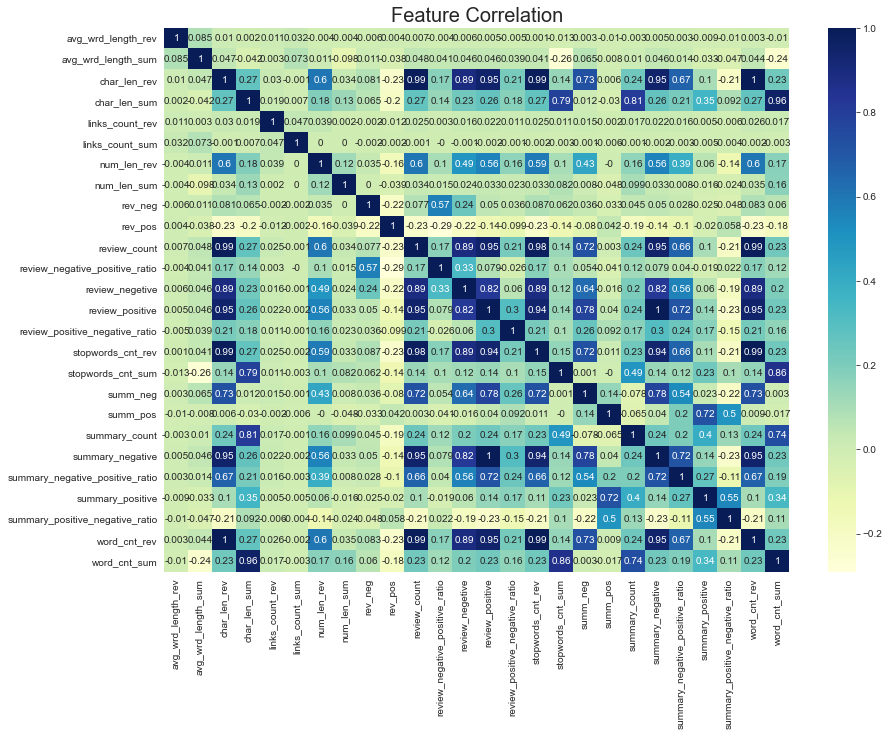

In [10]:
# Lets check the correlation between the newly created features
create_conrr(data[data.columns.difference(['verified', 'reviewText', 'review','summary_weighted'])])

We could see that the correlation between the features are significant for most of them.<br>
However for some of the features the correlation is very high.

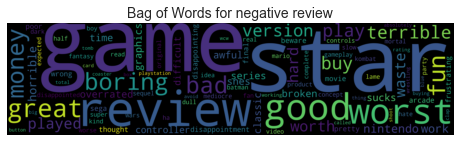

In [43]:
summary = stemming_word(data[data.review==0]['summary_weighted'][:1000],splitting = False,type_of = "lemm")
word_cloud(summary,title="Bag of Words for negative review")

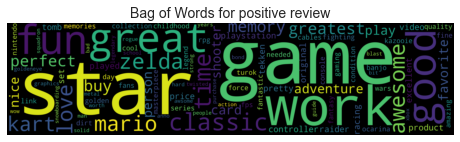

In [44]:
summary = stemming_word(data[data.review==1]['summary_weighted'][:1000],splitting = False,type_of = "lemm")
word_cloud(summary,title="Bag of Words for positive review")

We see a significant difference in the words used in two class labels

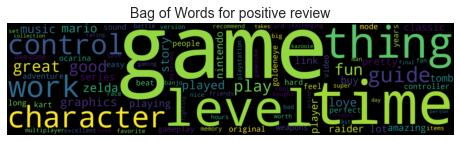

In [46]:
summary = stemming_word(data[data.review==1]['reviewText'][:1000],splitting = False,type_of = "lemm")
word_cloud(summary,title="Bag of Words for positive review")

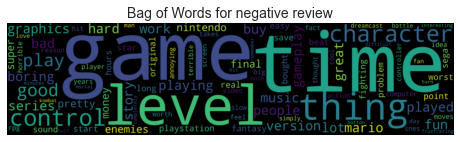

In [47]:
summary = stemming_word(data[data.review==0]['reviewText'][:1000],splitting = False,type_of = "lemm")
word_cloud(summary,title="Bag of Words for negative review")

We could see that the Summary text is much significantly different than the review text itself.

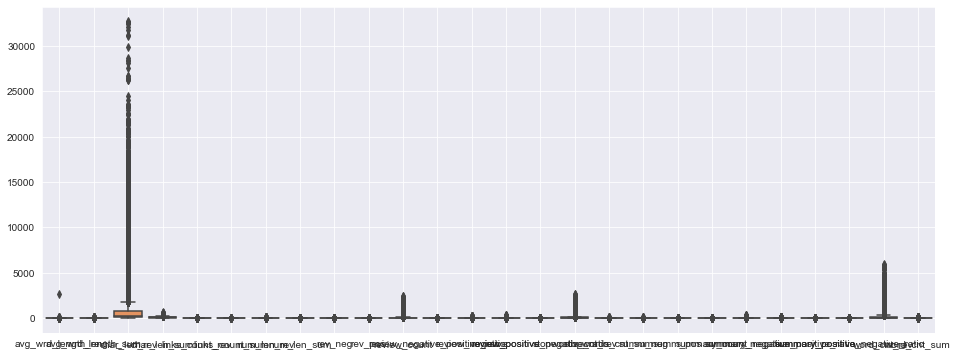

In [3]:
# Lets check the boxplot of our new features
sns.set_style('dark')
a4_dims = (16,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(ax=ax, data=data[data.columns.difference(['verified', 'reviewText', 'review','summary_weighted'])])
plt.grid()
plt.show()

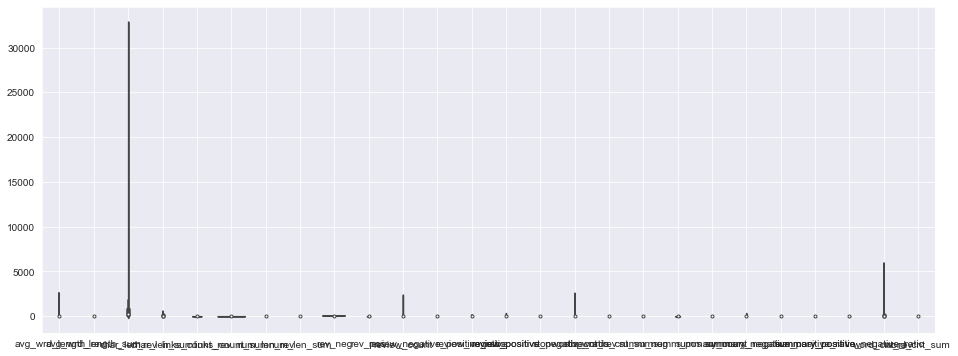

In [4]:
# Lets check the boxplot of our new features
sns.set_style('dark')
a4_dims = (16,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(ax=ax, data=data[data.columns.difference(['verified', 'reviewText', 'review','summary_weighted'])])
plt.grid()
plt.show()

# Modeling

In [7]:
# This function will provide result to oour classification model
def validate_result(y_true, y_pred,model="Model"):
    print(f"The Result for the {model} Classification is a Below\n")
    fig, ax = plt.subplots(figsize=(15,5))
    conf = confusion_matrix(y_true, y_pred).round(3)
    b = sns.heatmap(conf.round(3), cmap="YlGnBu",annot=True,ax = ax)
    b.axes.set_title("Confusion Matrix",fontsize=20)
    b.set_xlabel("Predicted Value",fontsize=16)
    b.set_ylabel("True Value",fontsize=16)
    b.tick_params(labelsize=16)
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred)*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred)*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred).round(3))
    print("Log Loss: ",log_loss(y_true, y_pred).round(3))
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Classification Report:\n",df.round(3))

In [8]:
# Returns a Sparce matrix from the data we have:
def pandas_to_sparse(data,rev,summ):
    mat2 = scipy.sparse.csr_matrix(data)
    mat1 = hstack([rev,summ])
    print("End of Sparse Matrix\n")
    return hstack([mat1,mat2])

### Bag of Words

In [33]:
# Snowball and BOW with 1gram
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='BOW',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='BOW',gram=1,feat_names=False)
X = pandas_to_sparse(data[data.columns.difference(['reviewText','summary_weighted'])].astype(float),summary,review)

In [14]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the Model Classification is a Below

Recall Score: 94.14243216633672 %
Precision Score: 95.37425326311951 %
F1 Score:  0.9475433941757504
Log Loss:  3.0960973884322245
Classification Report:
               precision    recall  f1-score       support
0              0.666687  0.719571  0.692120   15380.00000
1              0.953743  0.941424  0.947543   94459.00000
accuracy       0.910360  0.910360  0.910360       0.91036
macro avg      0.810215  0.830498  0.819832  109839.00000
weighted avg   0.913548  0.910360  0.911778  109839.00000


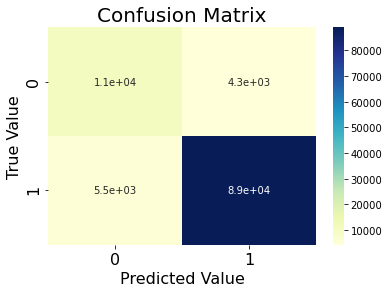

In [14]:
# Let us create a baseline model
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_test,clf.predict(X_test))

### TF-IDF

In [59]:
# Snowball and BOW with 1gram
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='tfidf',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='tfidf',gram=1,feat_names=False)
X = pandas_to_sparse(data[data.columns.difference(['reviewText','summary_weighted'])].astype(float),summary,review)

In [60]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the Model Classification is a Below

Recall Score: 97.19349135603807 %
Precision Score: 92.299958780299 %
F1 Score:  0.9468353908191786
Log Loss:  3.2420261359648856
Classification Report:
               precision    recall  f1-score        support
0              0.744408  0.502016  0.599643   15380.000000
1              0.923000  0.971935  0.946835   94459.000000
accuracy       0.906135  0.906135  0.906135       0.906135
macro avg      0.833704  0.736975  0.773239  109839.000000
weighted avg   0.897993  0.906135  0.898220  109839.000000


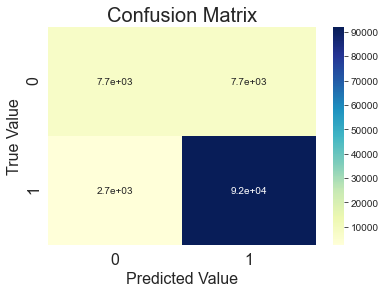

In [61]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_test,clf.predict(X_test))

In [9]:
# Plotting Featire Importance
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [10]:
# Check feature importance of the features created by us
# We would use BOW as it is giving better results
scaler = StandardScaler()
X = data[data.columns.difference(['verified','reviewText','summary_weighted','review'])]
y = data['review']
cols = X.columns
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

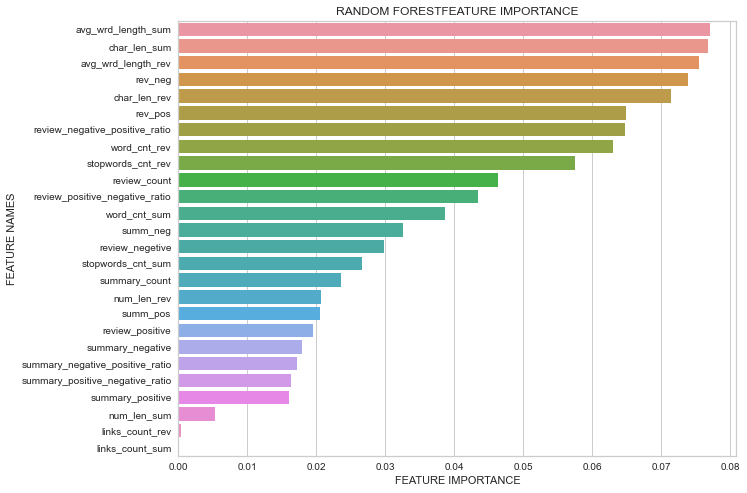

In [18]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
plot_feature_importance(clf.feature_importances_,cols,'RANDOM FOREST')

The Result for the RF with only the features created by us Classification is a Below

Recall Score: 96.988 %
Precision Score: 90.421 %
F1 Score:  0.936
Log Loss:  3.946
Classification Report:
               precision  recall  f1-score     support
0                 0.666   0.369     0.475   15380.000
1                 0.904   0.970     0.936   94459.000
accuracy          0.886   0.886     0.886       0.886
macro avg         0.785   0.669     0.705  109839.000
weighted avg      0.871   0.886     0.871  109839.000


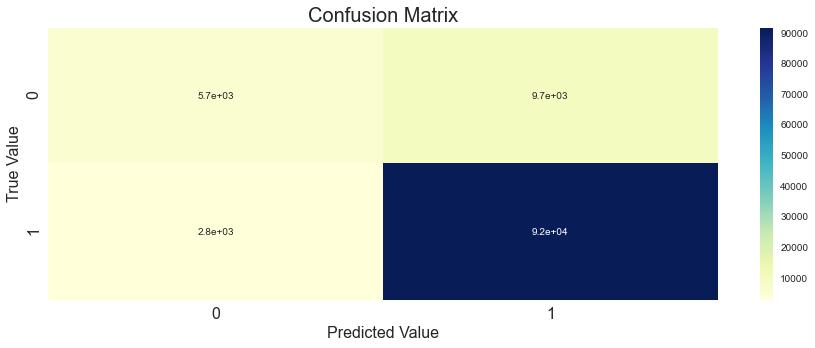

In [19]:
# We could see that apart from 2, all the features are providing significant improvemt to our model
# noe lets try to check how if the score of this
# We could see the lower minority class if performing very poorly
validate_result(y_test,clf.predict(X_test),"RF with only the features created by us")

The Result for the LR with Sampling and only features created by us Classification is a Below

Recall Score: 76.186 %
Precision Score: 94.882 %
F1 Score:  0.845
Log Loss:  8.294
Classification Report:
               precision  recall  f1-score    support
0                 0.338   0.748     0.466   15380.00
1                 0.949   0.762     0.845   94459.00
accuracy          0.760   0.760     0.760       0.76
macro avg         0.644   0.755     0.655  109839.00
weighted avg      0.863   0.760     0.792  109839.00


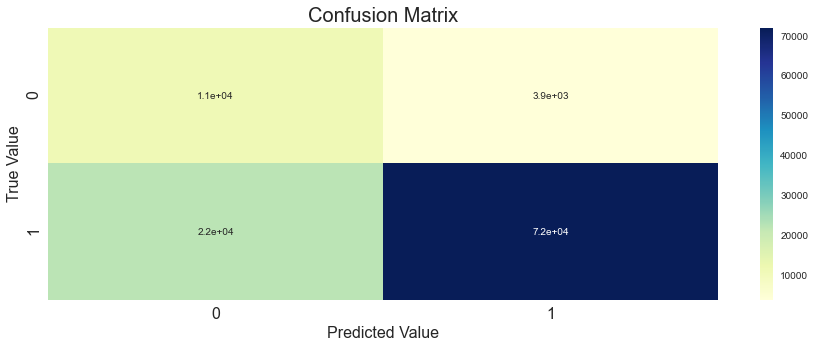

In [26]:
# Lets try Logistic regression now with sampling
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="SMOTE",strategy = "auto",n_jobs=3)
clf = LogisticRegression()
clf.fit(X_train_1,y_train_1)
validate_result(y_test,clf.predict(X_test),"LR with Sampling and only features created by us")

In [27]:
# Lets try checking with only reviretext and summary
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=1,feat_names=False)
X = hstack([review,summary])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector



The Result for the LR with only Text and Summary and sampling Classification is a Below

Recall Score: 95.566 %
Precision Score: 95.79 %
F1 Score:  0.957
Log Loss:  2.564
Classification Report:
               precision  recall  f1-score     support
0                 0.732   0.742     0.737   15380.000
1                 0.958   0.956     0.957   94459.000
accuracy          0.926   0.926     0.926       0.926
macro avg         0.845   0.849     0.847  109839.000
weighted avg      0.926   0.926     0.926  109839.000


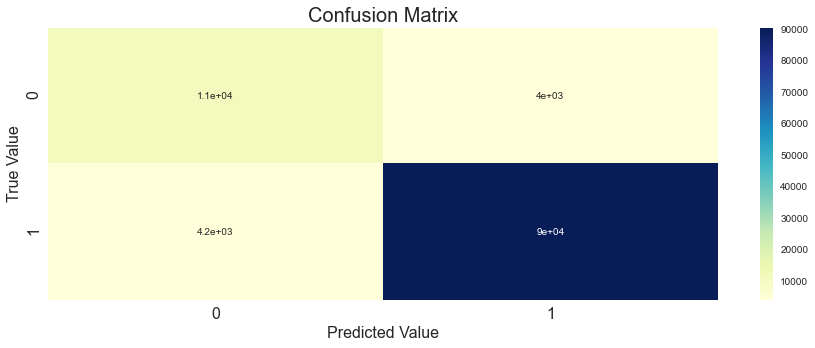

In [32]:
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="SMOTE",strategy = 0.3,n_jobs=5)
clf = LogisticRegression(n_jobs=5)
clf.fit(X_train_1,y_train_1)
validate_result(y_test,clf.predict(X_test),"LR with only Text and Summary and sampling")

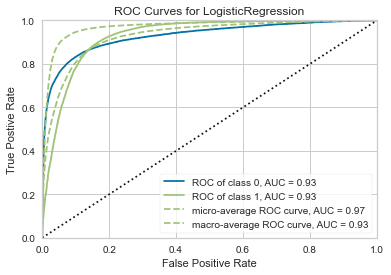

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [34]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [10]:
# Snowball and BOW with 1gram
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=1,feat_names=False)
X = pandas_to_sparse(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float),summary,review)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [11]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the Logistic Regression with SGD Classification is a Below

Recall Score: 96.85048539578018 %
Precision Score: 92.66642356468539 %
F1 Score:  0.9471226764259795
Log Loss:  3.2121504197908513
Classification Report:
               precision    recall  f1-score     support
0              0.732344  0.529259  0.614456   15380.000
1              0.926664  0.968505  0.947123   94459.000
accuracy       0.907000  0.907000  0.907000       0.907
macro avg      0.829504  0.748882  0.780789  109839.000
weighted avg   0.899455  0.907000  0.900542  109839.000


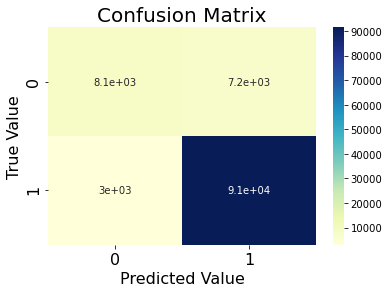

In [13]:
clf = SGDClassifier(loss='log')
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"Logistic Regression with SGD")

The Result for the Random Forest Classification is a Below

Recall Score: 100.0 %
Precision Score: 85.99768752446762 %
F1 Score:  0.9247178141734133
Log Loss:  4.83633935817153
Classification Report:
               precision    recall  f1-score        support
0              0.000000  0.000000  0.000000   15380.000000
1              0.859977  1.000000  0.924718   94459.000000
accuracy       0.859977  0.859977  0.859977       0.859977
macro avg      0.429988  0.500000  0.462359  109839.000000
weighted avg   0.739560  0.859977  0.795236  109839.000000


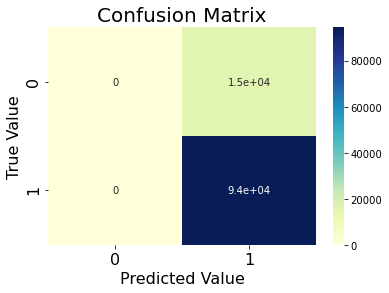

In [18]:
# Random Forest
rf_params = {"max_depth": list(range(2,7,1)), "min_samples_leaf": list(range(5,7,1))}
clf = RandomizedSearchCV(RandomForestClassifier(), rf_params)
clf.fit(X_train,y_train)
clf = clf.best_estimator_
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"Random Forest")

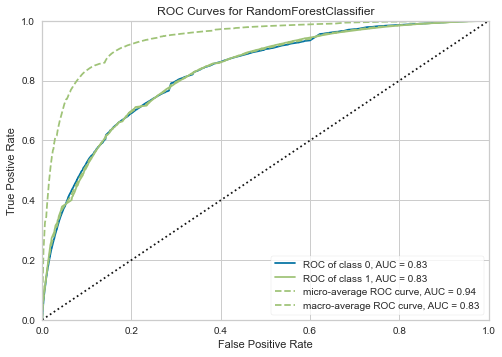

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [20]:
from yellowbrick.classifier import roc_auc
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

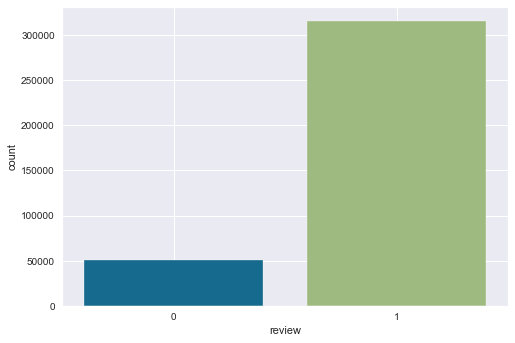

In [21]:
sns.set_style("dark")
sns.countplot(data['review'])
plt.grid()
plt.show()

In [23]:
data['review'].value_counts()

1    315342
0     50787
Name: review, dtype: int64

The Tree based algorithm is performing well. Lets try and see Decision Tree much more closely

In [15]:
# Snowball and BOW with 1gram
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=1,feat_names=False)
X = pandas_to_sparse(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float),summary,review)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [16]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the Model Classification is a Below

Recall Score: 97.78210652240654 %
Precision Score: 89.97866557559108 %
F1 Score:  0.9371822840038557
Log Loss:  3.8935838343443447
Classification Report:
               precision    recall  f1-score        support
0              0.708542  0.331144  0.451347   15380.000000
1              0.899787  0.977821  0.937182   94459.000000
accuracy       0.887271  0.887271  0.887271       0.887271
macro avg      0.804164  0.654483  0.694265  109839.000000
weighted avg   0.873008  0.887271  0.869154  109839.000000


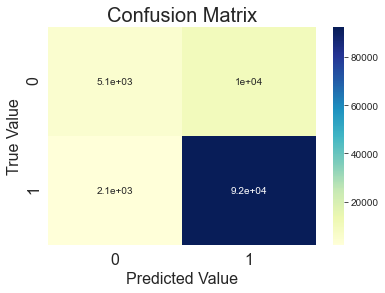

In [18]:
df_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
df_clf.fit(X_train,y_train)
validate_result(y_test,df_clf.predict(X_test))

In [10]:
# This function would return samples variables, i have used 4 different options of sampling in this case.
# Would try modelling on all the 4 sampled data and check which one performs better.
def sampling_data(X,y,option="SMOTE",strategy = "auto",n_jobs=1):
    if option.lower()=="smote":
        smo = SMOTE(random_state=52,sampling_strategy = strategy,n_jobs=n_jobs)
        smo.fit(X, y)
        X_resampled, y_resampled = smo.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="undersample":
        rus = RandomUnderSampler(random_state=42,sampling_strategy = strategy)
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="oversample":
        ros = RandomOverSampler(random_state=42,sampling_strategy = strategy)
        ros.fit(X, y)
        X_resampled, y_resampled = ros.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="nearmiss":
        near = NearMiss(sampling_strategy = strategy,n_jobs=n_jobs)
        near.fit(X, y)
        X_resampled, y_resampled = near.fit_sample(X, y)
        return X_resampled,y_resampled
    else:
        print("Please select from the below options: ")
        print("1: Undersample || 2: Oversample || 3: Nearmiss || 4. SMOTE")

The Result for the Model Classification is a Below

Recall Score: 78.83949650112747 %
Precision Score: 95.40592131391162 %
F1 Score:  0.8633518050499663
Log Loss:  7.412849553346347
Classification Report:
               precision    recall  f1-score        support
0              0.371091  0.766840  0.500148   15380.000000
1              0.954059  0.788395  0.863352   94459.000000
accuracy       0.785377  0.785377  0.785377       0.785377
macro avg      0.662575  0.777618  0.681750  109839.000000
weighted avg   0.872430  0.785377  0.812495  109839.000000


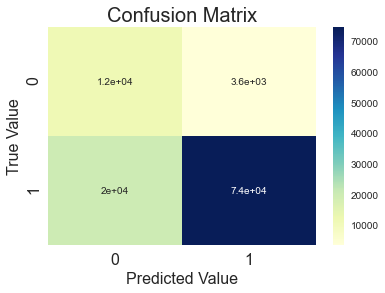

In [27]:
df_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="undersample",strategy = "auto")
df_clf.fit(X_train_1,y_train_1)
validate_result(y_test,df_clf.predict(X_test))

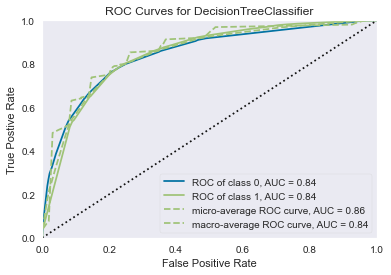

In [28]:
roc_auc(df_clf,X_train_1,y_train_1,X_test = X_test, y_test = y_test,classes=[0,1])
del X_train_1,y_train_1

The Result for the Random Forest with Undersampling Classification is a Below

Recall Score: 78.88925353857229 %
Precision Score: 95.12369475861013 %
F1 Score:  0.8624918256682697
Log Loss:  7.471653241395644
Classification Report:
               precision    recall  f1-score        support
0              0.366972  0.751625  0.493164   15380.000000
1              0.951237  0.788893  0.862492   94459.000000
accuracy       0.783674  0.783674  0.783674       0.783674
macro avg      0.659105  0.770259  0.677828  109839.000000
weighted avg   0.869426  0.783674  0.810777  109839.000000


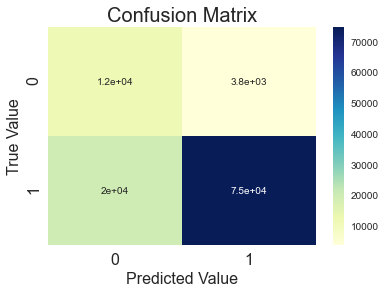

In [29]:
# Trying RF with undersampling
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="undersample",strategy = "auto")
clf.fit(X_train_1,y_train_1)
validate_result(y_test,clf.predict(X_test),"Random Forest with Undersampling")

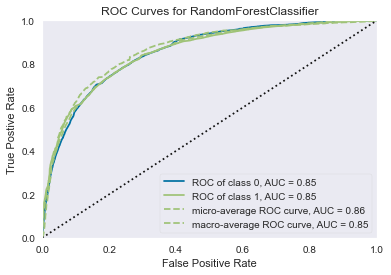

In [30]:
roc_auc(clf,X_train_1,y_train_1,X_test = X_test, y_test = y_test,classes=[0,1])
del X_train_1,y_train_1

The Result for the Random Forest with SMOTE Classification is a Below

Recall Score: 90.25820726452747 %
Precision Score: 91.06318892591642 %
F1 Score:  0.9065891122536327
Log Loss:  5.524617419258043
Classification Report:
               precision    recall  f1-score        support
0              0.432501  0.455982  0.443931   15380.000000
1              0.910632  0.902582  0.906589   94459.000000
accuracy       0.840048  0.840048  0.840048       0.840048
macro avg      0.671566  0.679282  0.675260  109839.000000
weighted avg   0.843682  0.840048  0.841806  109839.000000


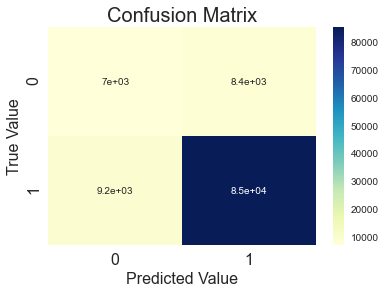

In [36]:
# Lets try with SMOTE
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="smote",strategy = "auto")
clf.fit(X_train_1,y_train_1)
validate_result(y_test,clf.predict(X_test),"Random Forest with SMOTE")

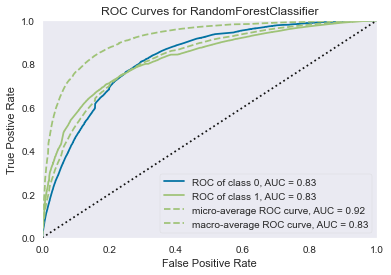

In [37]:
roc_auc(clf,X_train_1,y_train_1,X_test = X_test, y_test = y_test,classes=[0,1])
del X_train_1,y_train_1

Sampled data decrease the performance of our model

In [52]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBoost Classification is a Below

Recall Score: 98.398 %
Precision Score: 93.597 %
F1 Score:  0.959
Log Loss:  2.475
Classification Report:
               precision  recall  f1-score     support
0                 0.856   0.587     0.696   15380.000
1                 0.936   0.984     0.959   94459.000
accuracy          0.928   0.928     0.928       0.928
macro avg         0.896   0.785     0.828  109839.000
weighted avg      0.925   0.928     0.923  109839.000


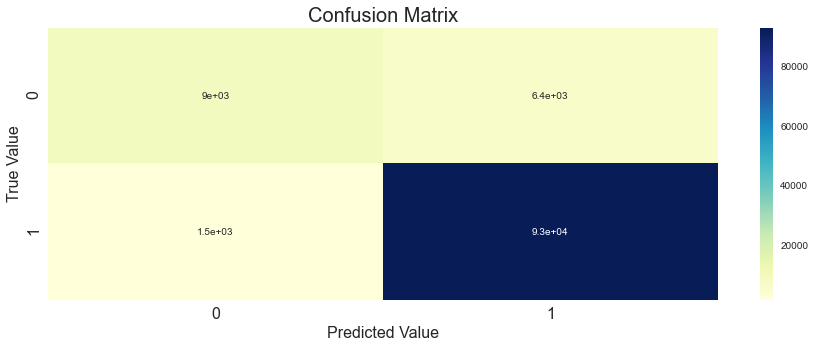

In [56]:
validate_result(y_test,clf.predict(X_test),"XGBoost")

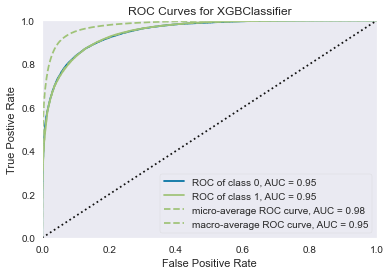

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [57]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

The best score we get is from XGBoost Classifier <br>
We would further try to tune our model to get even better results
However we can see that the class with less data points is performing bad.
Lets check and see if we standardize data performance

In [66]:
# Snowball and BOW with 1gram
scaler = StandardScaler()
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=1,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)

In [64]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the XGBoost Classification is a Below

Recall Score: 98.402 %
Precision Score: 93.568 %
F1 Score:  0.959
Log Loss:  2.484
Classification Report:
               precision  recall  f1-score     support
0                 0.856   0.585     0.695   15380.000
1                 0.936   0.984     0.959   94459.000
accuracy          0.928   0.928     0.928       0.928
macro avg         0.896   0.784     0.827  109839.000
weighted avg      0.925   0.928     0.922  109839.000


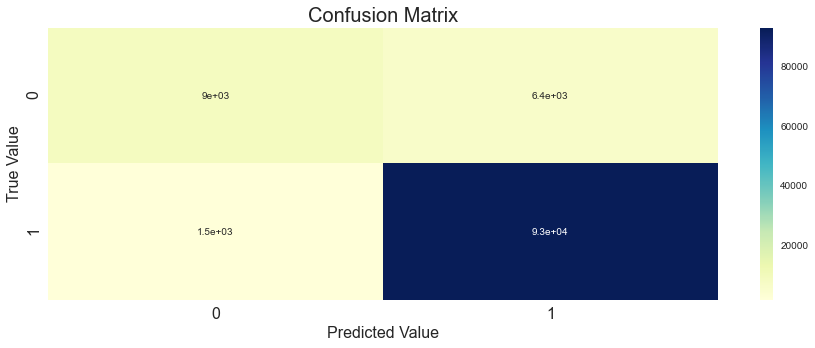

In [65]:
clf = XGBClassifier()
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"XGBoost")

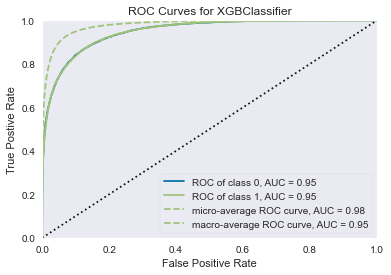

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [67]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [11]:
# Lets try with our TF-IDF
scaler = StandardScaler()
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='tfidf',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='tfidf',gram=1,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [12]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

The Result for the XGBoost with TF-IDF Classification is a Below

Recall Score: 98.312 %
Precision Score: 93.597 %
F1 Score:  0.959
Log Loss:  2.499
Classification Report:
               precision  recall  f1-score     support
0                 0.850   0.587     0.694   15380.000
1                 0.936   0.983     0.959   94459.000
accuracy          0.928   0.928     0.928       0.928
macro avg         0.893   0.785     0.827  109839.000
weighted avg      0.924   0.928     0.922  109839.000


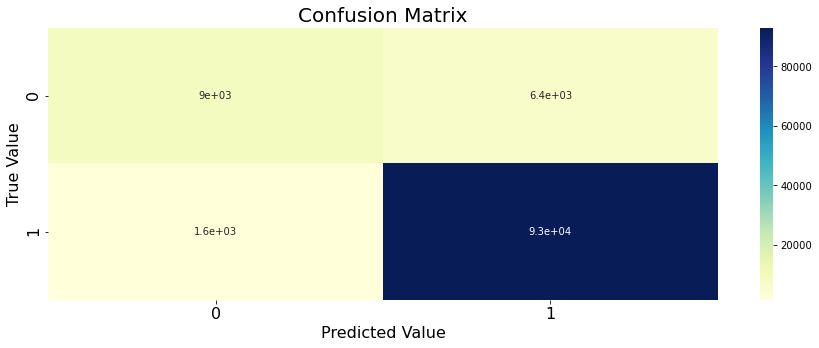

In [15]:
clf = XGBClassifier()
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"XGBoost with TF-IDF")

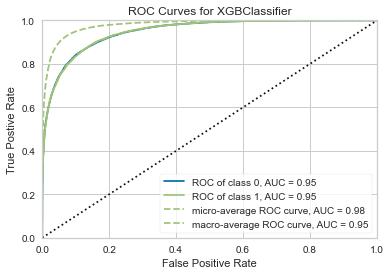

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [18]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

The Result for the XGBoost with TF-IDF Classification is a Below

Recall Score: 97.942 %
Precision Score: 95.209 %
F1 Score:  0.966
Log Loss:  2.075
Classification Report:
               precision  recall  f1-score    support
0                 0.847   0.697     0.765   15380.00
1                 0.952   0.979     0.966   94459.00
accuracy          0.940   0.940     0.940       0.94
macro avg         0.899   0.838     0.865  109839.00
weighted avg      0.937   0.940     0.937  109839.00


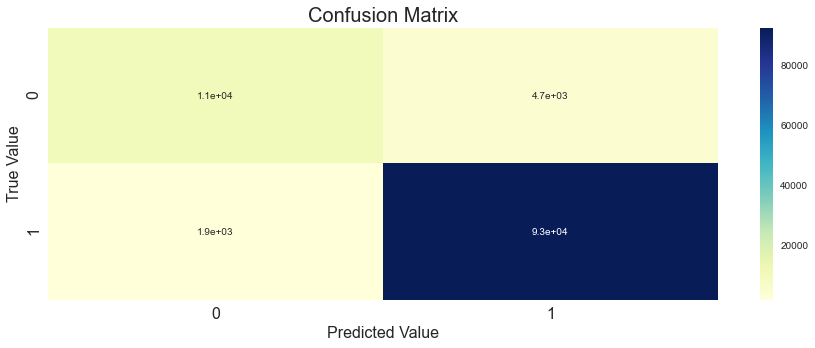

In [20]:
clf = LogisticRegressionCV(cv=5, random_state=0)
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"XGBoost with TF-IDF")

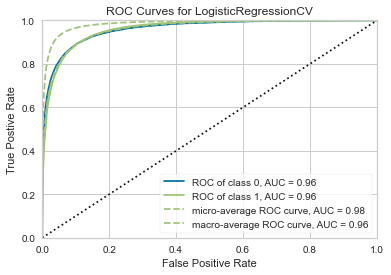

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegressionCV'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [21]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [23]:
del X_train, X_test, y_train, y_test

In [24]:
# Lets try Logistic Regression with BOW
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=1,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [25]:
# Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 11.4min finished


The Result for the logistic with TF-IDF Classification is a Below

Recall Score: 98.202 %
Precision Score: 94.604 %
F1 Score:  0.964
Log Loss:  2.198
Classification Report:
               precision  recall  f1-score     support
0                 0.856   0.656     0.743   15380.000
1                 0.946   0.982     0.964   94459.000
accuracy          0.936   0.936     0.936       0.936
macro avg         0.901   0.819     0.853  109839.000
weighted avg      0.933   0.936     0.933  109839.000


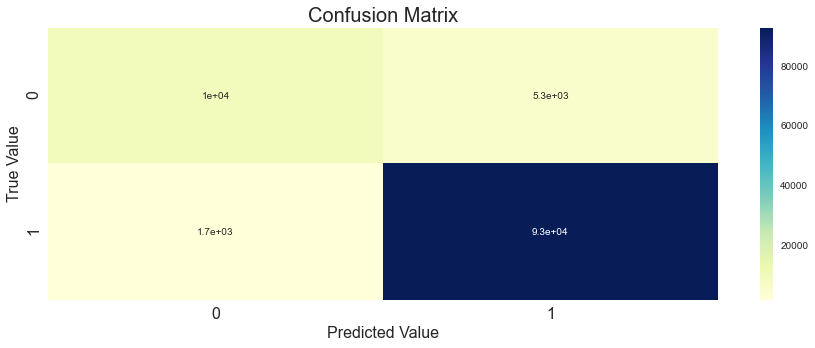

In [27]:
clf = LogisticRegressionCV(cv=5, random_state=0,max_iter=300,verbose=1,n_jobs=3)
clf.fit(X_train,y_train)
validate_result(y_test,clf.predict(X_test),"logistic with TF-IDF")

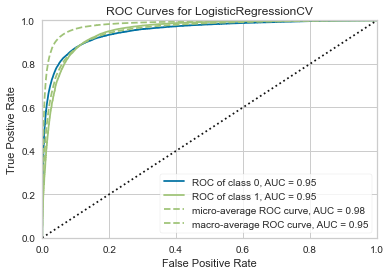

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegressionCV'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [28]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [29]:
scipy.sparse.save_npz('sparse_bow_snow_X.npz', X)

In [35]:
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='tfidf',gram=1,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='tfidf',gram=1,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)
scipy.sparse.save_npz('sparse_tfidf_snow_X_1gram.npz', X)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [37]:
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='tfidf',gram=2,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='tfidf',gram=2,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)
scipy.sparse.save_npz('sparse_tfidf_snow_X_2gram.npz', X)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [38]:
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=2,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=2,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)
scipy.sparse.save_npz('sparse_bow_snow_X_2gram.npz', X)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [39]:
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='tfidf',gram=3,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='tfidf',gram=3,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)
scipy.sparse.save_npz('sparse_tfidf_snow_X_3gram.npz', X)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [40]:
summary = stemming_word(data['summary_weighted'],splitting = False,type_of = "snow")
summary = text_to_numbers(summary,model='bow',gram=3,feat_names=False)
review = stemming_word(data['reviewText'],splitting = False,type_of = "snow")
review = text_to_numbers(review,model='bow',gram=3,feat_names=False)
X = pandas_to_sparse(scaler.fit_transform(data[data.columns.difference(['verified','reviewText','summary_weighted','review'])].astype(float)),summary,review)
scipy.sparse.save_npz('sparse_bow_snow_X_3gram.npz', X)

End of Word Stemming

End of Word String to Vector

End of Word Stemming

End of Word String to Vector

End of Sparse Matrix



In [11]:
X = scipy.sparse.load_npz('sparse_bow_snow_X_2gram.npz')

In [14]:
# 2 gram bow Seperating Data
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
param = {'C':[1000,100,10,1,0.1,0.001],'penalty':['l1','l2']}
rand = RandomizedSearchCV(LogisticRegression(n_jobs=3,verbose=1),param,verbose=100)
rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] penalty=l1, C=0.1 ...............................................
[CV] ..................... penalty=l1, C=0.1, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ..................... penalty=l1, C=0.1, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ..................... penalty=l1, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ..................... penalty=l1, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV] .................... penalty=l2, C=10, score=0.939, total= 2.2min
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s
[CV] penalty=l2, C=10 ................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV] .................... penalty=l2, C=10, score=0.939, total= 2.2min
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.4min remaining:    0.0s
[CV] penalty=l2, C=10 ................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV] .................... penalty=l2, C=10, score=0.939, total= 2.2min
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.5min remaining:    0.0s
[CV] penalty=l2, C=10 ................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV] .................... penalty=l2, C=10, score=0.938, total= 2.1min
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.6min remaining:    0.0s
[CV] penalty=l2, C=10 ................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] .................... penalty=l2, C=10, score=0.939, total= 2.0min
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.7min remaining:    0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ..................... penalty=l1, C=100, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 10.7min remaining:    0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ..................... penalty=l1, C=100, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 10.7min remaining:    0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ..................... penalty=l1, C=100, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 10.7min remaining:    0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ..................... penalty=l1, C=100, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  14 out of  14

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ................... penalty=l2, C=100, score=0.938, total= 2.0min
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 12.7min remaining:    0.0s
[CV] penalty=l2, C=100 ...............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ................... penalty=l2, C=100, score=0.938, total= 2.0min
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 14.7min remaining:    0.0s
[CV] penalty=l2, C=100 ...............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ................... penalty=l2, C=100, score=0.937, total= 2.0min
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 16.7min remaining:    0.0s
[CV] penalty=l2, C=100 ...............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ................... penalty=l2, C=100, score=0.935, total= 2.0min
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 18.7min remaining:    0.0s
[CV] penalty=l2, C=100 ...............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ................... penalty=l2, C=100, score=0.937, total= 2.1min
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 20.8min remaining:    0.0s
[CV] penalty=l2, C=0.001 .............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV] ................. penalty=l2, C=0.001, score=0.916, total= 1.3min
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 22.0min remaining:    0.0s
[CV] penalty=l2, C=0.001 .............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV] ................. penalty=l2, C=0.001, score=0.917, total= 1.3min
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 23.4min remaining:    0.0s
[CV] penalty=l2, C=0.001 .............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV] ................. penalty=l2, C=0.001, score=0.914, total= 1.2min
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 24.6min remaining:    0.0s
[CV] penalty=l2, C=0.001 .............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV] ................. penalty=l2, C=0.001, score=0.915, total= 1.1min
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 25.7min remaining:    0.0s
[CV] penalty=l2, C=0.001 .............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV] ................. penalty=l2, C=0.001, score=0.914, total= 1.3min
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 27.0min remaining:    0.0s
[CV] penalty=l2, C=1 .................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV] ..................... penalty=l2, C=1, score=0.941, total= 2.1min
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 29.0min remaining:    0.0s
[CV] penalty=l2, C=1 .................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV] ..................... penalty=l2, C=1, score=0.941, total= 2.1min
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 31.1min remaining:    0.0s
[CV] penalty=l2, C=1 .................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ..................... penalty=l2, C=1, score=0.941, total= 2.0min
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 33.1min remaining:    0.0s
[CV] penalty=l2, C=1 .................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ..................... penalty=l2, C=1, score=0.940, total= 2.0min
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 35.1min remaining:    0.0s
[CV] penalty=l2, C=1 .................................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] ..................... penalty=l2, C=1, score=0.941, total= 2.0min
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 37.1min remaining:    0.0s
[CV] penalty=l1, C=0.001 .............................................
[CV] ................... penalty=l1, C=0.001, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 37.1min remaining:    0.0s
[CV] penalty=l1, C=0.001 .............................................
[CV] ................... penalty=l1, C=0.001, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 37.1min remaining:    0.0s
[CV] penalty=l1, C=0.001 .............................................
[CV] ................... penalty=l1, C=0.001, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 37.2min remaining:    0.0s
[CV] penalty=l1, C=0.001 .............................................
[CV] ................... penalty=l1, C=0.001, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  34 out of  34

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.9min finished


[CV] .................. penalty=l2, C=1000, score=0.937, total= 1.9min
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 39.1min remaining:    0.0s
[CV] penalty=l2, C=1000 ..............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  1.9min finished


[CV] .................. penalty=l2, C=1000, score=0.938, total= 1.9min
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed: 41.0min remaining:    0.0s
[CV] penalty=l2, C=1000 ..............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV] .................. penalty=l2, C=1000, score=0.936, total= 2.1min
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 43.0min remaining:    0.0s
[CV] penalty=l2, C=1000 ..............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV] .................. penalty=l2, C=1000, score=0.937, total= 2.1min
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 45.1min remaining:    0.0s
[CV] penalty=l2, C=1000 ..............................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV] .................. penalty=l2, C=1000, score=0.936, total= 2.1min
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.2min remaining:    0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ...................... penalty=l1, C=10, score=nan, total=   0.3s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 47.2min remaining:    0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ...................... penalty=l1, C=10, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 47.2min remaining:    0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ...................... penalty=l1, C=10, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 47.2min remaining:    0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ...................... penalty=l1, C=10, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  49 out of  49

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.2min finished


RandomizedSearchCV(estimator=LogisticRegression(n_jobs=3, verbose=1),
                   param_distributions={'C': [1000, 100, 10, 1, 0.1, 0.001],
                                        'penalty': ['l1', 'l2']},
                   verbose=100)

In [19]:
clf = rand.best_estimator_
clf.fit(X_train,y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.3min finished


LogisticRegression(C=1, n_jobs=3, verbose=1)

The Result for the logistic with BOW 3 GRAM Classification is a Below

Recall Score: 97.914 %
Precision Score: 95.349 %
F1 Score:  0.966
Log Loss:  2.038
Classification Report:
               precision  recall  f1-score     support
0                 0.847   0.707     0.770   15380.000
1                 0.953   0.979     0.966   94459.000
accuracy          0.941   0.941     0.941       0.941
macro avg         0.900   0.843     0.868  109839.000
weighted avg      0.939   0.941     0.939  109839.000


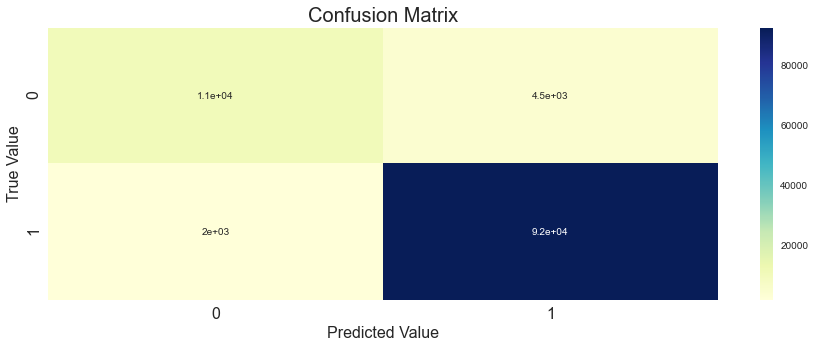

In [20]:
validate_result(y_test,clf.predict(X_test),"logistic with BOW 3 GRAM")

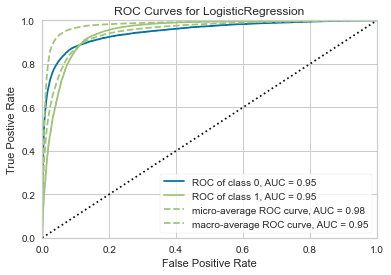

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [21]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [22]:
clf

LogisticRegression(C=1, n_jobs=3, verbose=1)

In [9]:
# Lets try with 3 gram tfidf
X = scipy.sparse.load_npz('sparse_tfidf_snow_X_2gram.npz')
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
clf = LogisticRegression(C=1, n_jobs=3, verbose=50)
clf.fit(X_train,y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  4.1min finished


LogisticRegression(C=1, n_jobs=3, verbose=50)

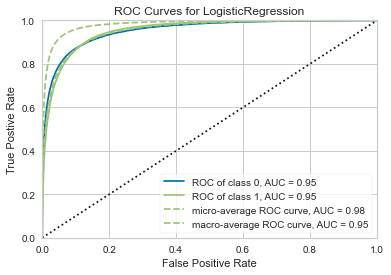

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [12]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

The Result for the Logistic with TFIDF 3 GRAM Classification is a Below

Recall Score: 98.121 %
Precision Score: 94.493 %
F1 Score:  0.963
Log Loss:  2.257
Classification Report:
               precision  recall  f1-score     support
0                 0.849   0.649     0.735   15380.000
1                 0.945   0.981     0.963   94459.000
accuracy          0.935   0.935     0.935       0.935
macro avg         0.897   0.815     0.849  109839.000
weighted avg      0.931   0.935     0.931  109839.000


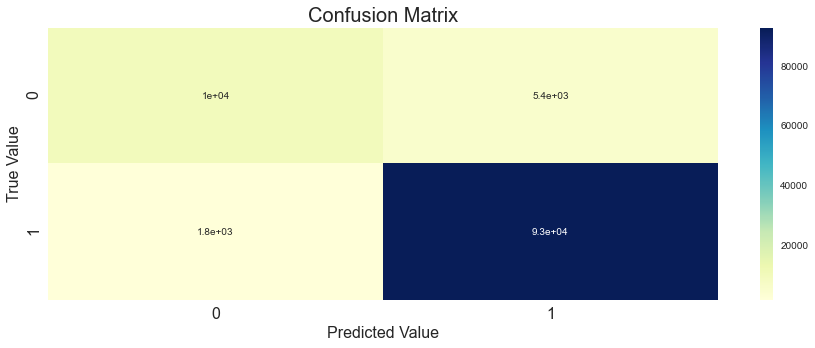

In [13]:
validate_result(y_test,clf.predict(X_test),"Logistic with TFIDF 3 GRAM")

In [16]:
X = scipy.sparse.load_npz('sparse_tfidf_snow_X_3gram.npz')
y = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [17]:
clf = LogisticRegression(C=1, n_jobs=3, verbose=50)
clf.fit(X_train,y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  3.9min finished


LogisticRegression(C=1, n_jobs=3, verbose=50)

The Result for the Logistic with TFIDF 3 GRAM Classification is a Below

Recall Score: 98.121 %
Precision Score: 94.493 %
F1 Score:  0.963
Log Loss:  2.257
Classification Report:
               precision  recall  f1-score     support
0                 0.849   0.649     0.735   15380.000
1                 0.945   0.981     0.963   94459.000
accuracy          0.935   0.935     0.935       0.935
macro avg         0.897   0.815     0.849  109839.000
weighted avg      0.931   0.935     0.931  109839.000


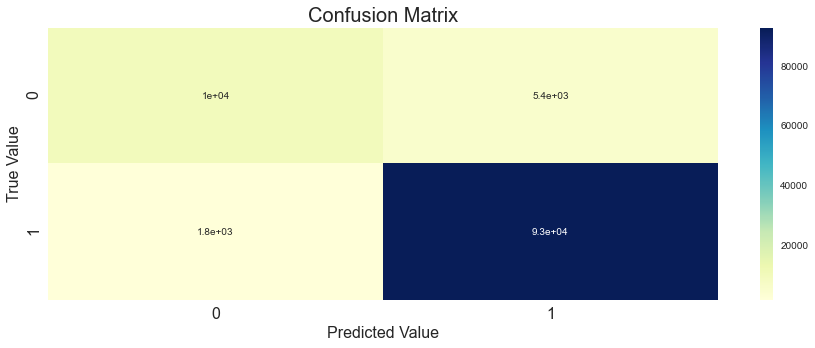

In [18]:
validate_result(y_test,clf.predict(X_test),"Logistic with TFIDF 3 GRAM")

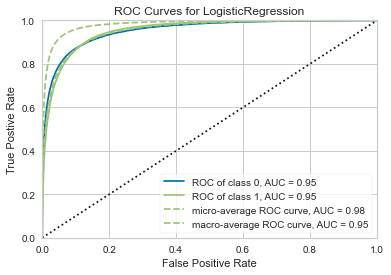

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [19]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [11]:
X = scipy.sparse.load_npz('sparse_bow_snow_X_2gram.npz')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
X_train,y_train = sampling_data(X_train,y_train,option="SMOTE",strategy = 0.30)

In [13]:
# Logistic Classifier
clf = SGDClassifier(loss='log',n_jobs=4,validation_fraction=0.2,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 67.91, NNZs: 4452282, Bias: 2.536258, T: 229717, Avg. loss: 1.338136
Total training time: 1.23 seconds.
-- Epoch 2
Norm: 44.44, NNZs: 4474013, Bias: 2.502851, T: 459434, Avg. loss: 0.127635
Total training time: 2.44 seconds.
-- Epoch 3
Norm: 36.87, NNZs: 4474013, Bias: 2.478872, T: 689151, Avg. loss: 0.100852
Total training time: 3.42 seconds.
-- Epoch 4
Norm: 33.66, NNZs: 4474013, Bias: 2.461877, T: 918868, Avg. loss: 0.097482
Total training time: 4.39 seconds.
-- Epoch 5
Norm: 32.05, NNZs: 4474013, Bias: 2.449953, T: 1148585, Avg. loss: 0.096350
Total training time: 5.31 seconds.
-- Epoch 6
Norm: 31.09, NNZs: 4474013, Bias: 2.441224, T: 1378302, Avg. loss: 0.096076
Total training time: 6.23 seconds.
-- Epoch 7
Norm: 30.47, NNZs: 4474013, Bias: 2.434495, T: 1608019, Avg. loss: 0.095488
Total training time: 7.15 seconds.
Convergence after 7 epochs took 7.27 seconds


SGDClassifier(early_stopping=True, loss='log', max_iter=5000, n_jobs=4,
              validation_fraction=0.2, verbose=10)

The Result for the Logistic with BOW 2 GRAM Classification is a Below

Recall Score: 97.335 %
Precision Score: 95.55 %
F1 Score:  0.964
Log Loss:  2.138
Classification Report:
               precision  recall  f1-score     support
0                 0.815   0.722     0.766   15380.000
1                 0.955   0.973     0.964   94459.000
accuracy          0.938   0.938     0.938       0.938
macro avg         0.885   0.847     0.865  109839.000
weighted avg      0.936   0.938     0.937  109839.000


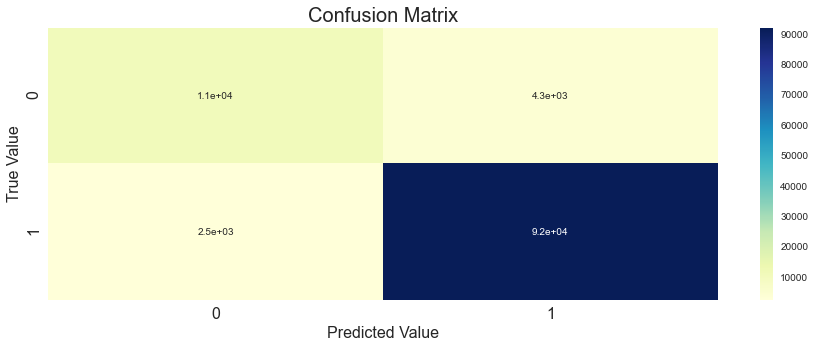

In [14]:
validate_result(y_test,clf.predict(X_test),"Logistic with BOW 2 GRAM")

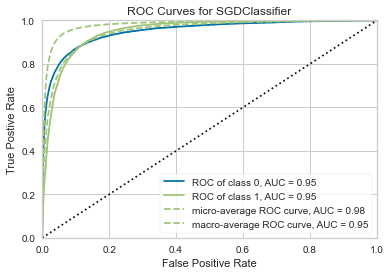

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [15]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [16]:
# SVM Classifier
clf = SGDClassifier(loss='hinge',n_jobs=4,validation_fraction=0.2,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 74.34, NNZs: 905352, Bias: 2.068371, T: 229717, Avg. loss: 1.352459
Total training time: 0.64 seconds.
-- Epoch 2
Norm: 51.22, NNZs: 1166210, Bias: 2.034550, T: 459434, Avg. loss: 0.148267
Total training time: 1.40 seconds.
-- Epoch 3
Norm: 42.50, NNZs: 1290285, Bias: 2.009147, T: 689151, Avg. loss: 0.094297
Total training time: 2.16 seconds.
-- Epoch 4
Norm: 38.29, NNZs: 1366330, Bias: 1.991031, T: 918868, Avg. loss: 0.079883
Total training time: 2.92 seconds.
-- Epoch 5
Norm: 35.67, NNZs: 1415745, Bias: 1.971922, T: 1148585, Avg. loss: 0.063226
Total training time: 3.73 seconds.
-- Epoch 6
Norm: 34.01, NNZs: 1453681, Bias: 1.960098, T: 1378302, Avg. loss: 0.058106
Total training time: 4.55 seconds.
Convergence after 6 epochs took 4.69 seconds


SGDClassifier(early_stopping=True, max_iter=5000, n_jobs=4,
              validation_fraction=0.2, verbose=10)

The Result for the SVM with BOW 2 GRAM Classification is a Below

Recall Score: 96.15 %
Precision Score: 96.17 %
F1 Score:  0.962
Log Loss:  2.281
Classification Report:
               precision  recall  f1-score     support
0                 0.764   0.765     0.764   15380.000
1                 0.962   0.961     0.962   94459.000
accuracy          0.934   0.934     0.934       0.934
macro avg         0.863   0.863     0.863  109839.000
weighted avg      0.934   0.934     0.934  109839.000


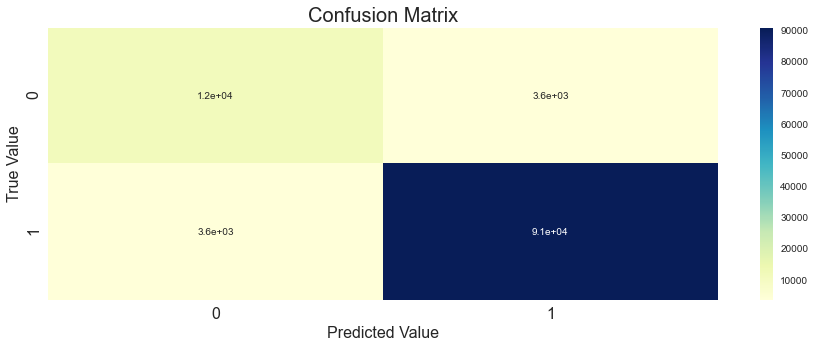

In [17]:
validate_result(y_test,clf.predict(X_test),"SVM with BOW 2 GRAM")

In [19]:
# Lets try a bit more sampling
X = scipy.sparse.load_npz('sparse_bow_snow_X_2gram.npz')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
X_train,y_train = sampling_data(X_train,y_train,option="SMOTE",strategy = 0.50)

In [21]:
# Logistic Classifier
clf = SGDClassifier(loss='log',n_jobs=4,validation_fraction=0.2,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 61.49, NNZs: 4488328, Bias: 1.807507, T: 265059, Avg. loss: 1.236763
Total training time: 0.94 seconds.
-- Epoch 2
Norm: 41.68, NNZs: 4506582, Bias: 1.774012, T: 530118, Avg. loss: 0.129002
Total training time: 2.04 seconds.
-- Epoch 3
Norm: 36.05, NNZs: 4506582, Bias: 1.756675, T: 795177, Avg. loss: 0.109685
Total training time: 3.11 seconds.
-- Epoch 4
Norm: 33.72, NNZs: 4506582, Bias: 1.746676, T: 1060236, Avg. loss: 0.110291
Total training time: 4.15 seconds.
-- Epoch 5
Norm: 32.50, NNZs: 4506582, Bias: 1.739294, T: 1325295, Avg. loss: 0.106528
Total training time: 5.21 seconds.
-- Epoch 6
Norm: 31.79, NNZs: 4506582, Bias: 1.732959, T: 1590354, Avg. loss: 0.106084
Total training time: 6.29 seconds.
Convergence after 6 epochs took 6.44 seconds


SGDClassifier(early_stopping=True, loss='log', max_iter=5000, n_jobs=4,
              validation_fraction=0.2, verbose=10)

The Result for the Logistic Regression with BOW 2 GRAM Classification is a Below

Recall Score: 95.633 %
Precision Score: 96.081 %
F1 Score:  0.959
Log Loss:  2.456
Classification Report:
               precision  recall  f1-score     support
0                 0.739   0.760     0.750   15380.000
1                 0.961   0.956     0.959   94459.000
accuracy          0.929   0.929     0.929       0.929
macro avg         0.850   0.858     0.854  109839.000
weighted avg      0.930   0.929     0.929  109839.000


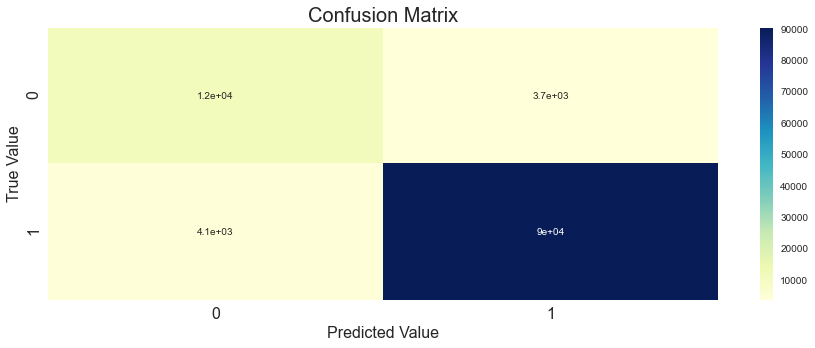

In [24]:
validate_result(y_test,clf.predict(X_test),"Logistic Regression with BOW 2 GRAM")

In [23]:
# SVM Classifier
clf = SGDClassifier(loss='hinge',n_jobs=4,validation_fraction=0.2,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 69.19, NNZs: 991950, Bias: 1.854759, T: 265059, Avg. loss: 1.315591
Total training time: 0.41 seconds.
-- Epoch 2
Norm: 48.51, NNZs: 1245610, Bias: 1.815920, T: 530118, Avg. loss: 0.134286
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 41.12, NNZs: 1368968, Bias: 1.788392, T: 795177, Avg. loss: 0.088202
Total training time: 1.39 seconds.
-- Epoch 4
Norm: 37.60, NNZs: 1443264, Bias: 1.766419, T: 1060236, Avg. loss: 0.073874
Total training time: 1.93 seconds.
-- Epoch 5
Norm: 35.57, NNZs: 1490653, Bias: 1.753019, T: 1325295, Avg. loss: 0.066541
Total training time: 2.45 seconds.
-- Epoch 6
Norm: 34.27, NNZs: 1522071, Bias: 1.737987, T: 1590354, Avg. loss: 0.062287
Total training time: 2.97 seconds.
Convergence after 6 epochs took 3.05 seconds


SGDClassifier(early_stopping=True, max_iter=5000, n_jobs=4,
              validation_fraction=0.2, verbose=10)

The Result for the Logistic Regression with BOW 2 GRAM Classification is a Below

Recall Score: 95.633 %
Precision Score: 96.081 %
F1 Score:  0.959
Log Loss:  2.456
Classification Report:
               precision  recall  f1-score     support
0                 0.739   0.760     0.750   15380.000
1                 0.961   0.956     0.959   94459.000
accuracy          0.929   0.929     0.929       0.929
macro avg         0.850   0.858     0.854  109839.000
weighted avg      0.930   0.929     0.929  109839.000


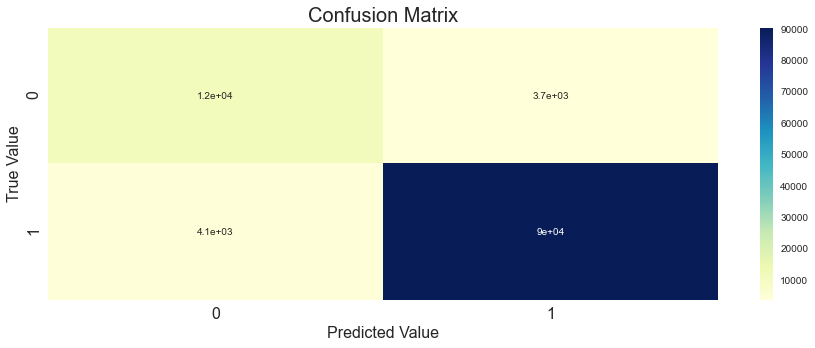

In [25]:
validate_result(y_test,clf.predict(X_test),"Logistic Regression with BOW 2 GRAM")

In [26]:
# # Lets try a tfidf and 2 gram
X = scipy.sparse.load_npz('sparse_tfidf_snow_X_2gram.npz')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
X_train,y_train = sampling_data(X_train,y_train,option="SMOTE",strategy = 0.50)

In [28]:
# Logistic Classifier
clf = SGDClassifier(loss='log',n_jobs=4,validation_fraction=0.3,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 35.65, NNZs: 134143, Bias: 2.474804, T: 231926, Avg. loss: 0.636011
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 32.20, NNZs: 134143, Bias: 1.882316, T: 463852, Avg. loss: 0.209668
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 31.21, NNZs: 134143, Bias: 1.639589, T: 695778, Avg. loss: 0.201027
Total training time: 0.72 seconds.
-- Epoch 4
Norm: 30.78, NNZs: 134143, Bias: 1.504459, T: 927704, Avg. loss: 0.198158
Total training time: 0.99 seconds.
-- Epoch 5
Norm: 30.55, NNZs: 134143, Bias: 1.421559, T: 1159630, Avg. loss: 0.196849
Total training time: 1.25 seconds.
-- Epoch 6
Norm: 30.38, NNZs: 134143, Bias: 1.365153, T: 1391556, Avg. loss: 0.196124
Total training time: 1.51 seconds.
Convergence after 6 epochs took 1.57 seconds


SGDClassifier(early_stopping=True, loss='log', max_iter=5000, n_jobs=4,
              validation_fraction=0.3, verbose=10)

The Result for the Logistic Regression with BOW 2 GRAM Classification is a Below

Recall Score: 95.458 %
Precision Score: 95.625 %
F1 Score:  0.955
Log Loss:  2.646
Classification Report:
               precision  recall  f1-score     support
0                 0.724   0.732     0.728   15380.000
1                 0.956   0.955     0.955   94459.000
accuracy          0.923   0.923     0.923       0.923
macro avg         0.840   0.843     0.842  109839.000
weighted avg      0.924   0.923     0.924  109839.000


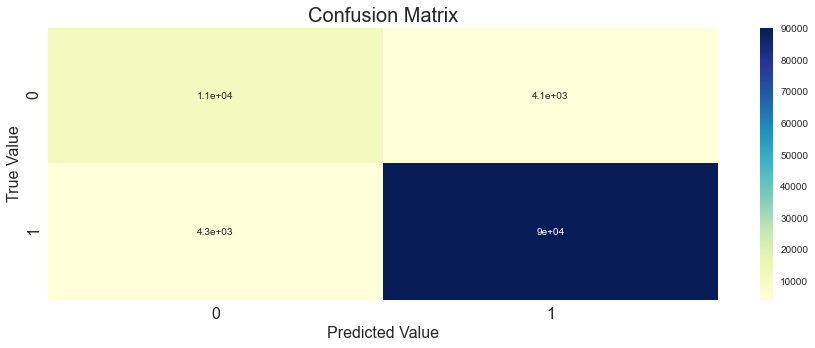

In [29]:
validate_result(y_test,clf.predict(X_test),"Logistic Regression with BOW 2 GRAM")

In [30]:
# Logistic Classifier
clf = SGDClassifier(loss='hinge',n_jobs=4,validation_fraction=0.3,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 42.25, NNZs: 75678, Bias: 3.326742, T: 231926, Avg. loss: 1.089012
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 35.91, NNZs: 87762, Bias: 2.032093, T: 463852, Avg. loss: 0.225321
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 33.76, NNZs: 94639, Bias: 1.570855, T: 695778, Avg. loss: 0.196079
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 32.94, NNZs: 99033, Bias: 1.326495, T: 927704, Avg. loss: 0.185624
Total training time: 0.82 seconds.
-- Epoch 5
Norm: 32.46, NNZs: 101561, Bias: 1.178195, T: 1159630, Avg. loss: 0.178067
Total training time: 1.04 seconds.
-- Epoch 6
Norm: 32.16, NNZs: 103546, Bias: 1.089828, T: 1391556, Avg. loss: 0.175950
Total training time: 1.29 seconds.
-- Epoch 7
Norm: 31.99, NNZs: 104795, Bias: 1.018660, T: 1623482, Avg. loss: 0.172442
Total training time: 1.60 seconds.
Convergence after 7 epochs took 1.70 seconds


SGDClassifier(early_stopping=True, max_iter=5000, n_jobs=4,
              validation_fraction=0.3, verbose=10)

The Result for the Logistic Regression with BOW 2 GRAM Classification is a Below

Recall Score: 95.618 %
Precision Score: 96.051 %
F1 Score:  0.958
Log Loss:  2.469
Classification Report:
               precision  recall  f1-score     support
0                 0.738   0.759     0.748   15380.000
1                 0.961   0.956     0.958   94459.000
accuracy          0.929   0.929     0.929       0.929
macro avg         0.849   0.857     0.853  109839.000
weighted avg      0.929   0.929     0.929  109839.000


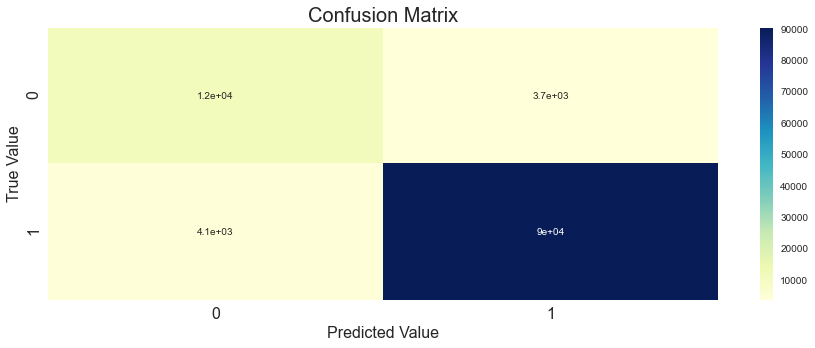

In [31]:
validate_result(y_test,clf.predict(X_test),"Logistic Regression with BOW 2 GRAM")

In [74]:
# # Lets try a tfidf and 2 gram
X = scipy.sparse.load_npz('sparse_bow_snow_X_2gram.npz')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [75]:
X_train,y_train = sampling_data(X_train,y_train,option="oversample",strategy = 0.20,n_jobs=3)

In [76]:
# Logistic Classifier
clf = SGDClassifier(loss='log',n_jobs=4,validation_fraction=0.2,verbose=10,early_stopping=True,max_iter=5000)
clf.fit(X_train,y_train)

-- Epoch 1
Norm: 72.90, NNZs: 4395346, Bias: 2.745492, T: 212047, Avg. loss: 1.474552
Total training time: 0.52 seconds.
-- Epoch 2
Norm: 45.59, NNZs: 4418662, Bias: 2.701339, T: 424094, Avg. loss: 0.119474
Total training time: 1.14 seconds.
-- Epoch 3
Norm: 36.96, NNZs: 4418750, Bias: 2.677921, T: 636141, Avg. loss: 0.087956
Total training time: 1.69 seconds.
-- Epoch 4
Norm: 33.14, NNZs: 4418750, Bias: 2.665785, T: 848188, Avg. loss: 0.082192
Total training time: 2.28 seconds.
-- Epoch 5
Norm: 31.18, NNZs: 4418750, Bias: 2.656403, T: 1060235, Avg. loss: 0.081240
Total training time: 2.84 seconds.
-- Epoch 6
Norm: 30.03, NNZs: 4418750, Bias: 2.649592, T: 1272282, Avg. loss: 0.080974
Total training time: 3.42 seconds.
Convergence after 6 epochs took 3.49 seconds


SGDClassifier(early_stopping=True, loss='log', max_iter=5000, n_jobs=4,
              validation_fraction=0.2, verbose=10)

The Result for the Logistic Regression with BOW 2 GRAM Classification is a Below

Recall Score: 97.842 %
Precision Score: 95.078 %
F1 Score:  0.964
Log Loss:  2.145
Classification Report:
               precision  recall  f1-score     support
0                 0.839   0.689     0.756   15380.000
1                 0.951   0.978     0.964   94459.000
accuracy          0.938   0.938     0.938       0.938
macro avg         0.895   0.834     0.860  109839.000
weighted avg      0.935   0.938     0.935  109839.000


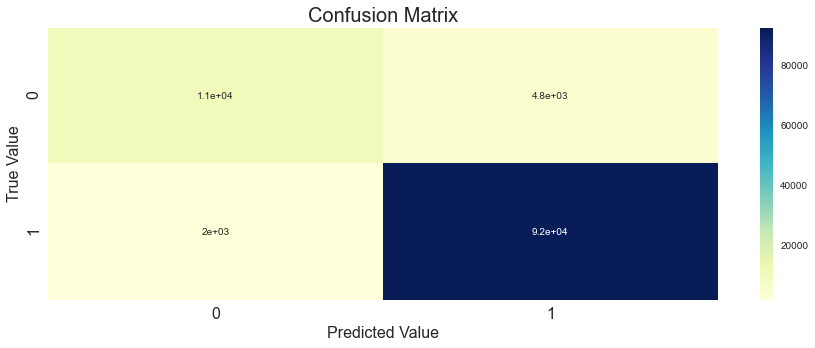

In [77]:
validate_result(y_test,clf.predict(X_test),"Logistic Regression with BOW 2 GRAM")

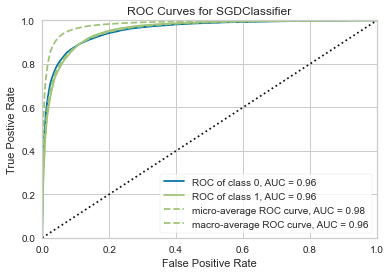

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [78]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

In [11]:
# Lets try sampling XGBoost and see the results
X = scipy.sparse.load_npz('sparse_bow_snow_X_2gram.npz')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
X_train_1,y_train_1 = sampling_data(X_train,y_train,option="oversample",strategy = 0.25,n_jobs=4)

In [19]:
# Lets try to tune
xgb = XGBClassifier(booster='gblinear', random_state=0,learning_rate=0.10,n_jobs=4)

The Result for the XGB with sampling Classification is a Below

Recall Score: 96.221 %
Precision Score: 93.692 %
F1 Score:  0.949
Log Loss:  3.047
Classification Report:
               precision  recall  f1-score     support
0                 0.722   0.602     0.657   15380.000
1                 0.937   0.962     0.949   94459.000
accuracy          0.912   0.912     0.912       0.912
macro avg         0.829   0.782     0.803  109839.000
weighted avg      0.907   0.912     0.908  109839.000


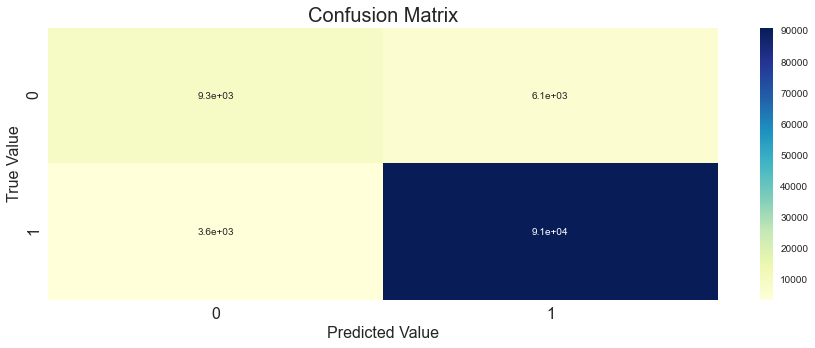

In [20]:
xgb.fit(X_train_1,y_train_1)
validate_result(y_test,xgb.predict(X_test),"XGB with sampling")